In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.transforms import GaussianBlur
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, zoom, mean as ndimage_mean
from skimage.transform import resize
import cv2


c:\Users\Varun\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Varun\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [98]:
# Functions for pixellation

def upsample_nearest(image, new_width, new_height):

    old_height, old_width = image.shape[-2:]
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Create the coordinate grid for the new image
    x_indices = (np.arange(new_width) / scale_x).astype(int)
    y_indices = (np.arange(new_height) / scale_y).astype(int)

    # Use advanced indexing to map the input pixels to the new grid
    upsampled_image = image[:,y_indices[:, None], x_indices]
    return upsampled_image

def downsample_to_fixed_size(image, target_size):

    num_channels, input_height, input_width = image.shape
    target_rows, target_cols = target_size

    # Calculate the scaling factors
    row_scale = input_height / target_rows
    col_scale = input_width / target_cols

    # Create an empty array for the downsampled image
    downsampled_image = np.zeros((num_channels,target_rows, target_cols), dtype=np.float32)

    for row in range(target_rows):
        for col in range(target_cols):
            # Determine the boundaries of the region in the original image
            row_start = int(row * row_scale)
            row_end = int((row + 1) * row_scale)
            col_start = int(col * col_scale)
            col_end = int((col + 1) * col_scale)

            # Extract the region and compute the average for each channel
            region = image[:,row_start:row_end, col_start:col_end]
            downsampled_image[:,row, col] = region.mean(axis=(1, 2))

    return downsampled_image.astype(image.dtype)

# Taken from https://github.com/hendrycks/robustness/blob/master/ImageNet-C/imagenet_c/imagenet_c/corruptions.py
def snow(x0, severity=1):
    c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

    x0 = np.array(x0, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

    #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = np.clip((snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

    #snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                              cv2.IMREAD_UNCHANGED) / 255.
    snow_layer = snow_layer[..., np.newaxis]

    x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
    return np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255



In [109]:
class coldDiff:
    def __init__(self, steps=300, size=28, loss_type='L2'):
        self.steps = steps
        self.size = size
        self.loss_type = loss_type

        
    def blur(self, x0, t, base_sigma=1.0):
        sigma_t = torch.sqrt(t*base_sigma**2).detach().cpu().numpy()
        x0_cpu = x0.detach().cpu().numpy()
        blurred_imgs = [gaussian_filter(x0_cpu[i], sigma=(0, sigma_t[i], sigma_t[i])) for i in range(len(sigma_t))]
        return torch.from_numpy(np.stack(blurred_imgs)).to(device)
        # return GaussianBlur(5, sigma_t)

    def vignette(self,x0,t): # Masking in the paper
        x0_cpu = x0.detach().cpu().numpy()

        pass


    def pixellate(self,x0,t,final_resolution=4): # Super resolution in the paper

        original_w,original_h = x0.shape[2],x0.shape[3]
                
        w,h = original_w,original_h
        pixellated_imgs = x0.detach().cpu().numpy()

        # Convert to list of numpy arrays
        pixellated_imgs = [pixellated_imgs[i].astype(np.float32) for i in range(len(pixellated_imgs))]
        while w > final_resolution and h > final_resolution:
            if(w//2 < final_resolution and h//2 < final_resolution):
                target_width = final_resolution
                target_height = final_resolution
            else:
                target_width = w//2
                target_height = h//2
            # Downsample the image using average pooling
            for i in range(len(pixellated_imgs)):
                if t[i] > 0:
                    
                    pixellated_imgs[i] = downsample_to_fixed_size(pixellated_imgs[i], (target_height, target_width))
                    #print(f"pixellated_imgs[{i}].shape:{pixellated_imgs[i].shape}, target_width:{target_width}, target_height:{target_height}")
             
            w,h = w//2,h//2
            
            t = t - 1    
        # Up sample the image to the original resolution (original_w,original_h) using nearest neighbour interpolation

        pixellated_imgs = [upsample_nearest(pixellated_imgs[i], original_w, original_h) for i in range(len(pixellated_imgs))]


        return torch.from_numpy(np.stack(pixellated_imgs)).to(device)
    
    def inpainting(self,x0,t,base_variance=1): #Base variance is beta in the paper
        w,h = x0.shape[2],x0.shape[3]
        center_x,center_y = np.random.randint(0,w, size = x0.shape[0]),np.random.randint(0,h,x0.shape[0])
        variance = base_variance + 0.5*t.detach().cpu().numpy()
        # 2d gaussian curve with center at rand_x,rand_y and peak value = 1, discretized 

        x0 = x0.detach().cpu().numpy()
        gaussian_mask = np.zeros_like(x0, dtype=float)

        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        gaussian = np.stack([np.exp(-((x - center_x[i])**2 + (y - center_y[i])**2) / (2 * variance[i])) for i in range(len(x0))])
        gaussian = 1 - gaussian

        # Normalize the gaussian mask
        gaussian = gaussian / np.max(gaussian, axis=(1,2), keepdims=True)

        # Add extra channel dimension as 2nd dimension
        gaussian = gaussian[:,None,:,:]
    
        # Apply the mask to the image
        inpainted_imgs = x0 * gaussian
     
        return torch.from_numpy(inpainted_imgs).float().to(device)

    def snow(self,x0, severity=1):
        c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
            (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
            (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
            (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
            (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

        x0 = x0.detach().cpu().numpy() / 255.
    
        snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

        #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
        snow_layer[snow_layer < c[3]] = 0

        snow_layer = (np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

        snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                                cv2.IMREAD_UNCHANGED) / 255.
        snow_layer = snow_layer[..., np.newaxis]

        x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
        snowified_images =  np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
        
        return torch.from_numpy(snowified_images).to(device)

    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,)) #Should this be self.steps+1?
    
    def sample(self, model, batch_size):
        output_shape = (batch_size, 1, 28, 28)
        t = self.steps
        model.eval()
        #x_prev = x_t
        # For now just use a black image
        x_prev = torch.zeros(output_shape).to(device)
        for s in tqdm(range(t, 0, -1)):
            s_ = (torch.ones(batch_size)*s).long().to(device)
            pred_x0 = model(x_prev, s_)
            x_prev = x_prev - self.blur(pred_x0, s_) + self.blur(pred_x0, s_-1)
        return pred_x0

In [110]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [111]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [112]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [113]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [114]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [115]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [116]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [107]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [119]:
EPOCHS = 100
batch_size = 8
image_size = 28
learning_rate = 3e-4


# Steps for diffusion process - changes based on the function used

steps = 100

FASHION_MNIST = False

# Import dataset
if (FASHION_MNIST):
    dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transforms, download=True)
else:
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

# LIMIT THE DATASET
LIMIT = True
if LIMIT:
    num_samples = 6000
    dataset = torch.utils.data.Subset(dataset, range(num_samples))
    test_dataset = torch.utils.data.Subset(test_dataset, range(num_samples//6))

    print("LIMITED DATASET")
    print(len(dataset))
    print(len(test_dataset))

else:
    print("FULL DATASET")
    print(len(dataset))
    print(len(test_dataset))
# dataset = torch.utils.data.Subset(dataset, range(1000))
# test_dataset = torch.utils.data.Subset(test_dataset, range(1000))


train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
diffusion = coldDiff(size=image_size, steps = steps)
length = len(train_loader)
print(length)

train_losses = []
val_losses = []



LIMITED DATASET
6000
1000
750


tensor([11, 88,  5, 90, 27, 94, 19, 48])


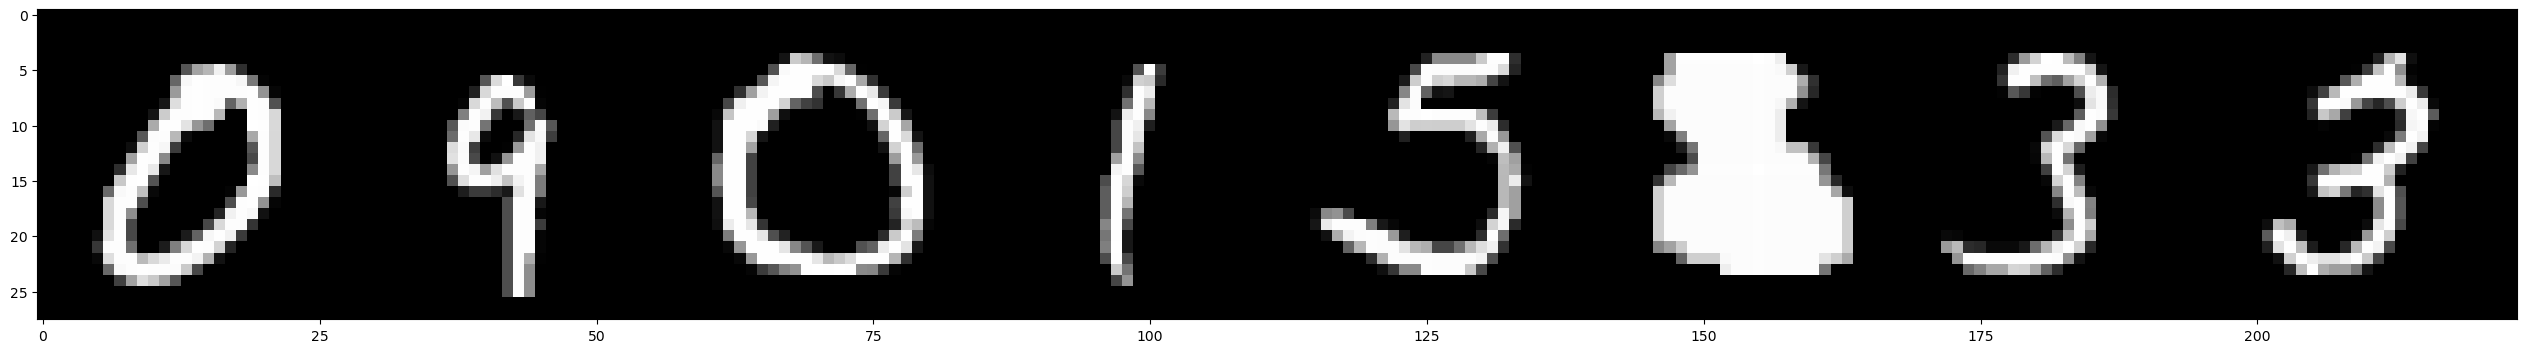

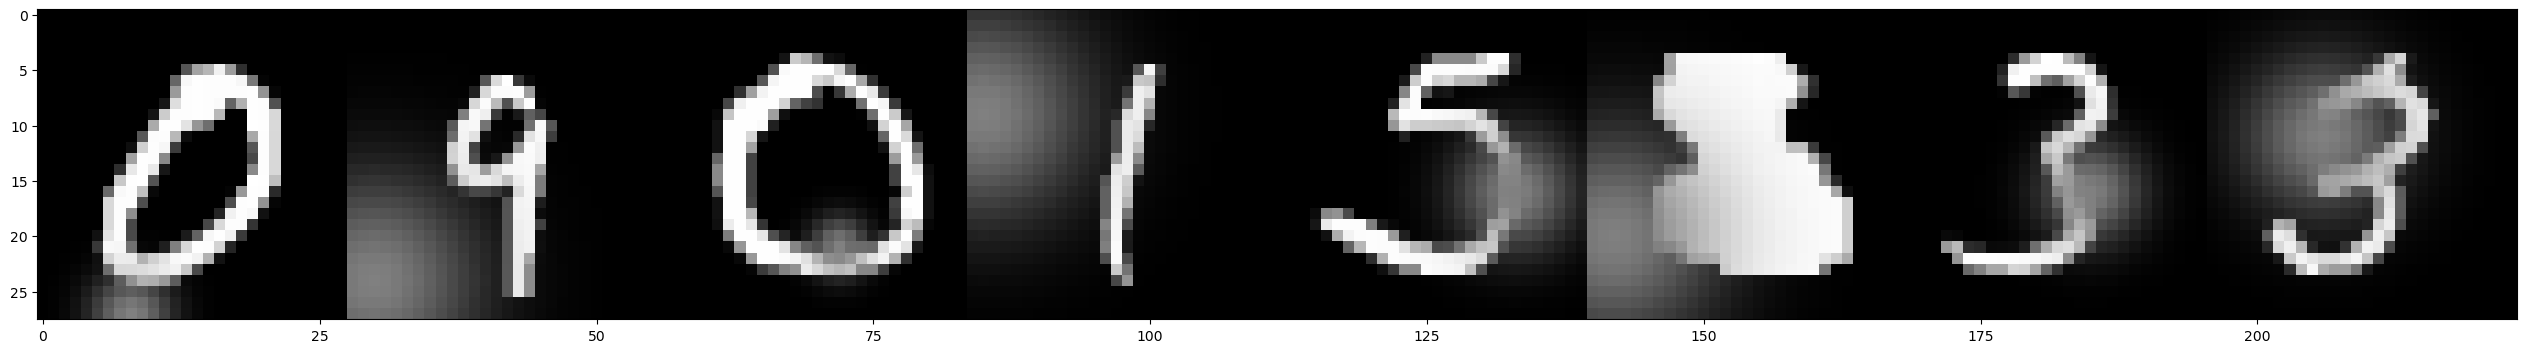

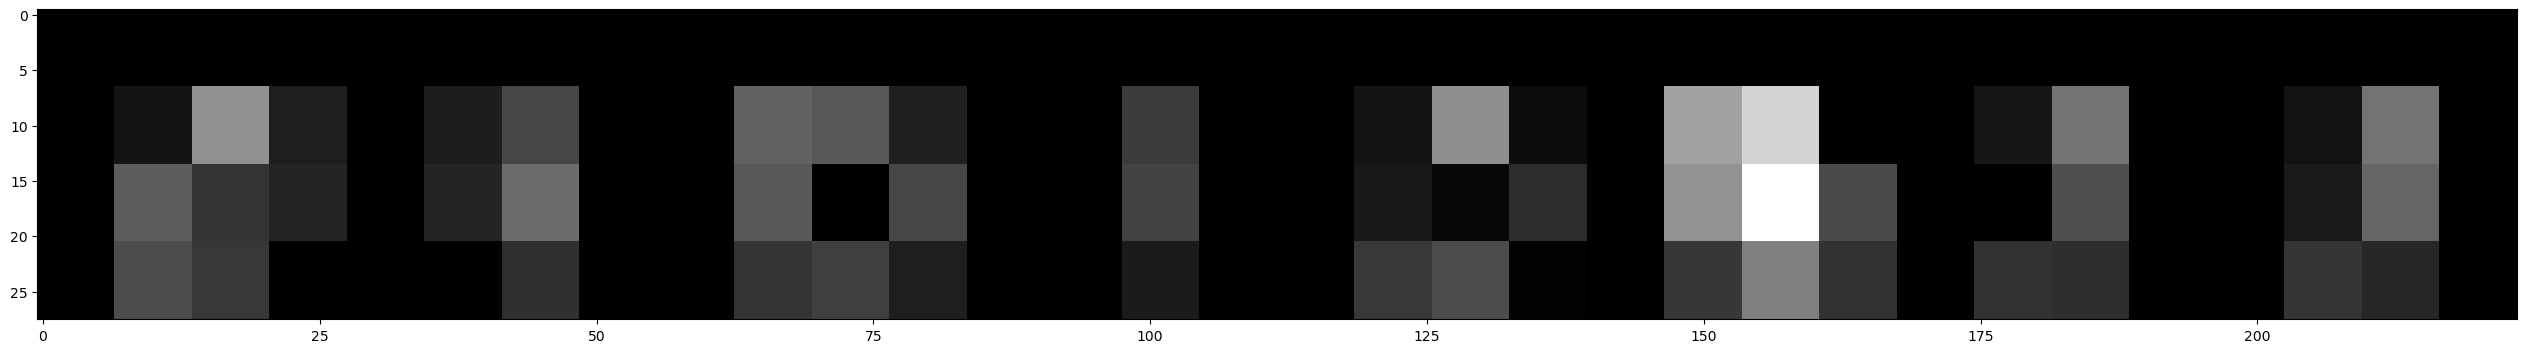

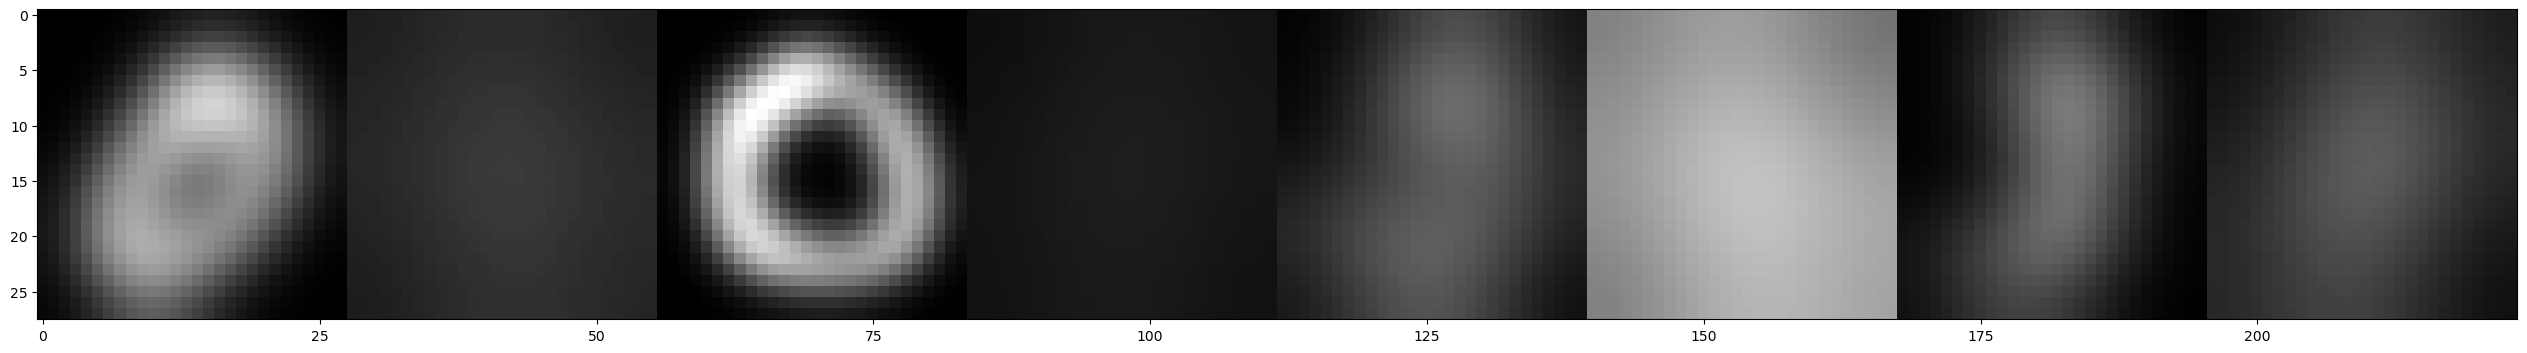

In [120]:
for x, _ in train_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0])
    print(t)
    # Plot the images
    plot_images(x)
    x_t = diffusion.inpainting(x, t)
    plot_images(x_t)
    x_t = diffusion.pixellate(x, t)
    plot_images(x_t)
    x_t = diffusion.blur(x, t)
    plot_images(x_t)
    #x_t = diffusion.snow(x)
    #plot_images(x_t)
    
    break

Epoch  0


100%|██████████| 100/100 [00:02<00:00, 39.94it/s]


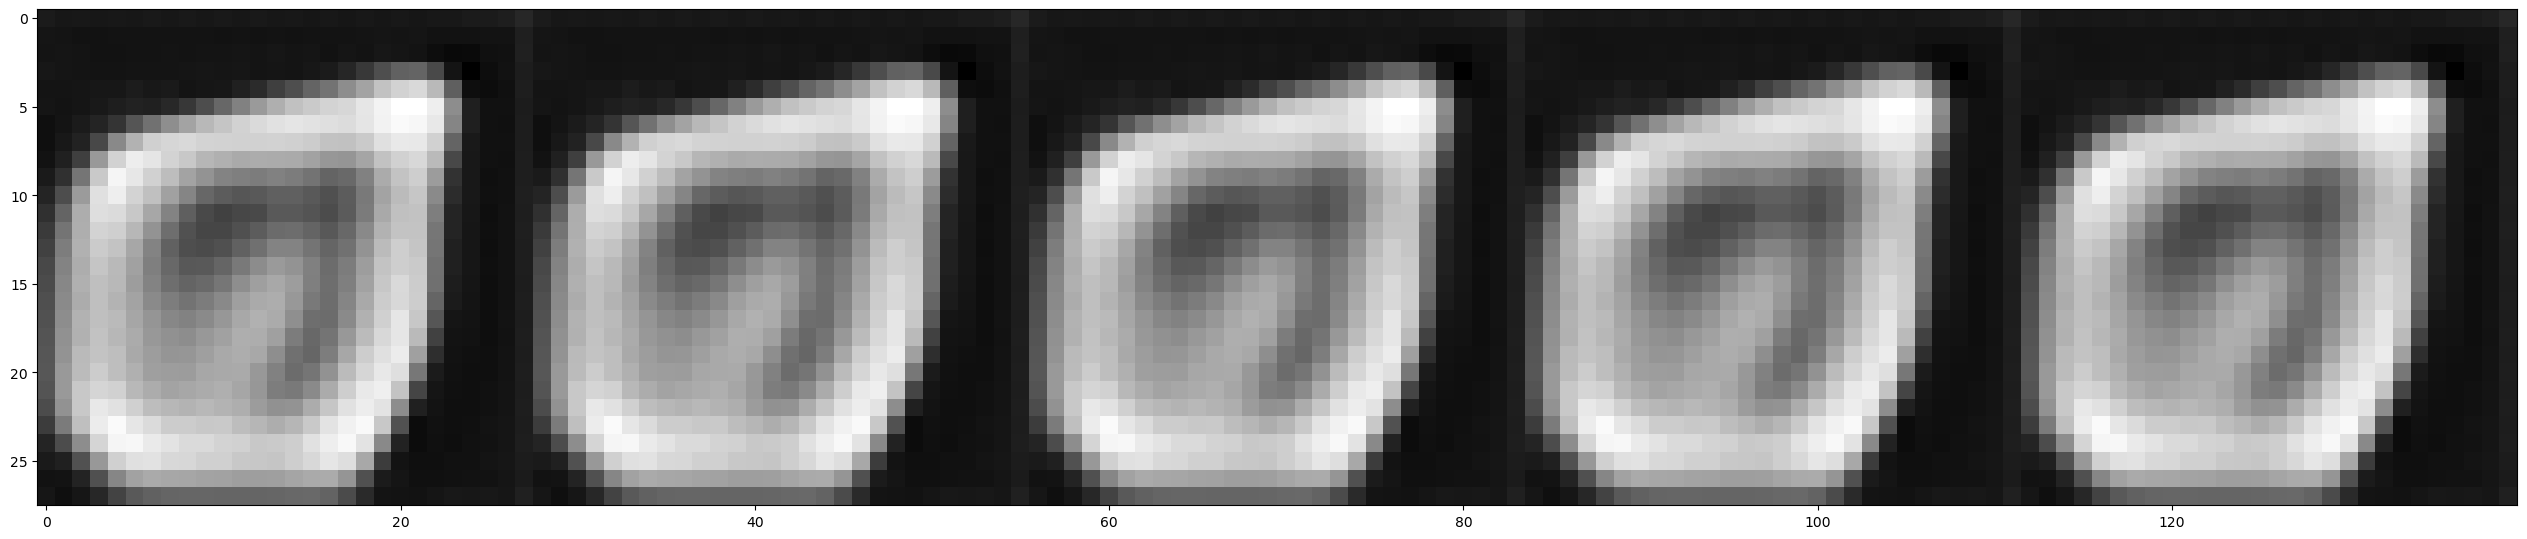

Epoch [1/100] | Train Loss: 0.2170 | Validation Loss: 0.1580
Epoch  1


100%|██████████| 750/750 [00:50<00:00, 14.73it/s]


Epoch [2/100] | Train Loss: 0.1471 | Validation Loss: 0.1338
Epoch  2


100%|██████████| 750/750 [00:51<00:00, 14.50it/s]


Epoch [3/100] | Train Loss: 0.1256 | Validation Loss: 0.1095
Epoch  3


100%|██████████| 100/100 [00:02<00:00, 40.19it/s]


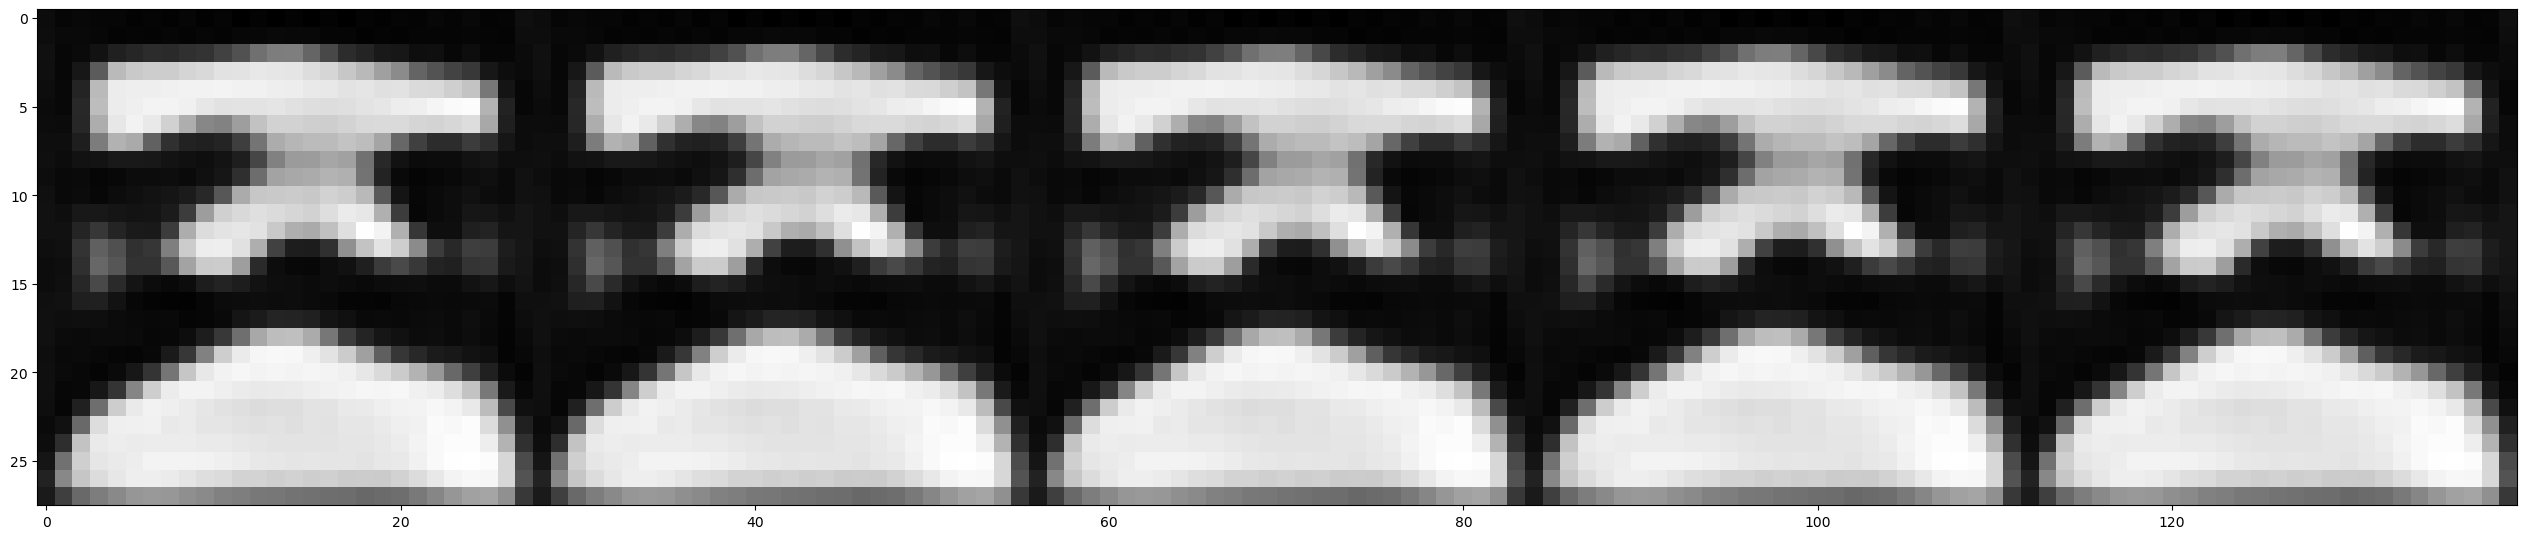

Epoch [4/100] | Train Loss: 0.1127 | Validation Loss: 0.1093
Epoch  4


100%|██████████| 750/750 [00:51<00:00, 14.48it/s]


Epoch [5/100] | Train Loss: 0.0996 | Validation Loss: 0.0944
Epoch  5


100%|██████████| 750/750 [00:51<00:00, 14.59it/s]


Epoch [6/100] | Train Loss: 0.0935 | Validation Loss: 0.0863
Epoch  6


100%|██████████| 100/100 [00:01<00:00, 60.24it/s]


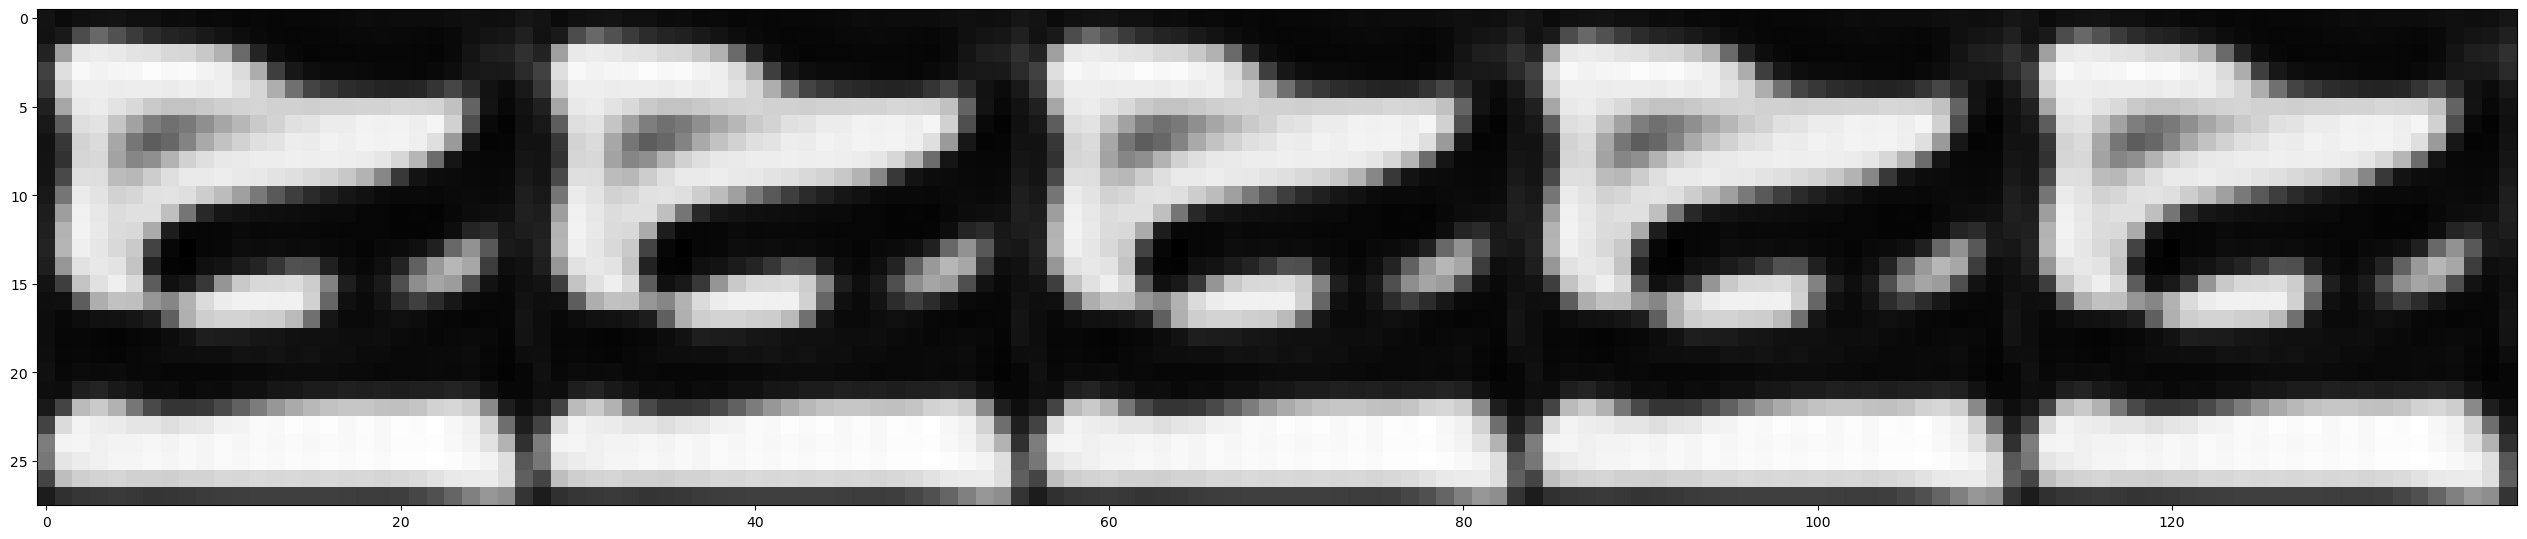

Epoch [7/100] | Train Loss: 0.0865 | Validation Loss: 0.0835
Epoch  7


100%|██████████| 750/750 [00:48<00:00, 15.51it/s]


Epoch [8/100] | Train Loss: 0.0840 | Validation Loss: 0.0866
Epoch  8


100%|██████████| 750/750 [00:48<00:00, 15.48it/s]


Epoch [9/100] | Train Loss: 0.0793 | Validation Loss: 0.0712
Epoch  9


100%|██████████| 100/100 [00:01<00:00, 60.26it/s]


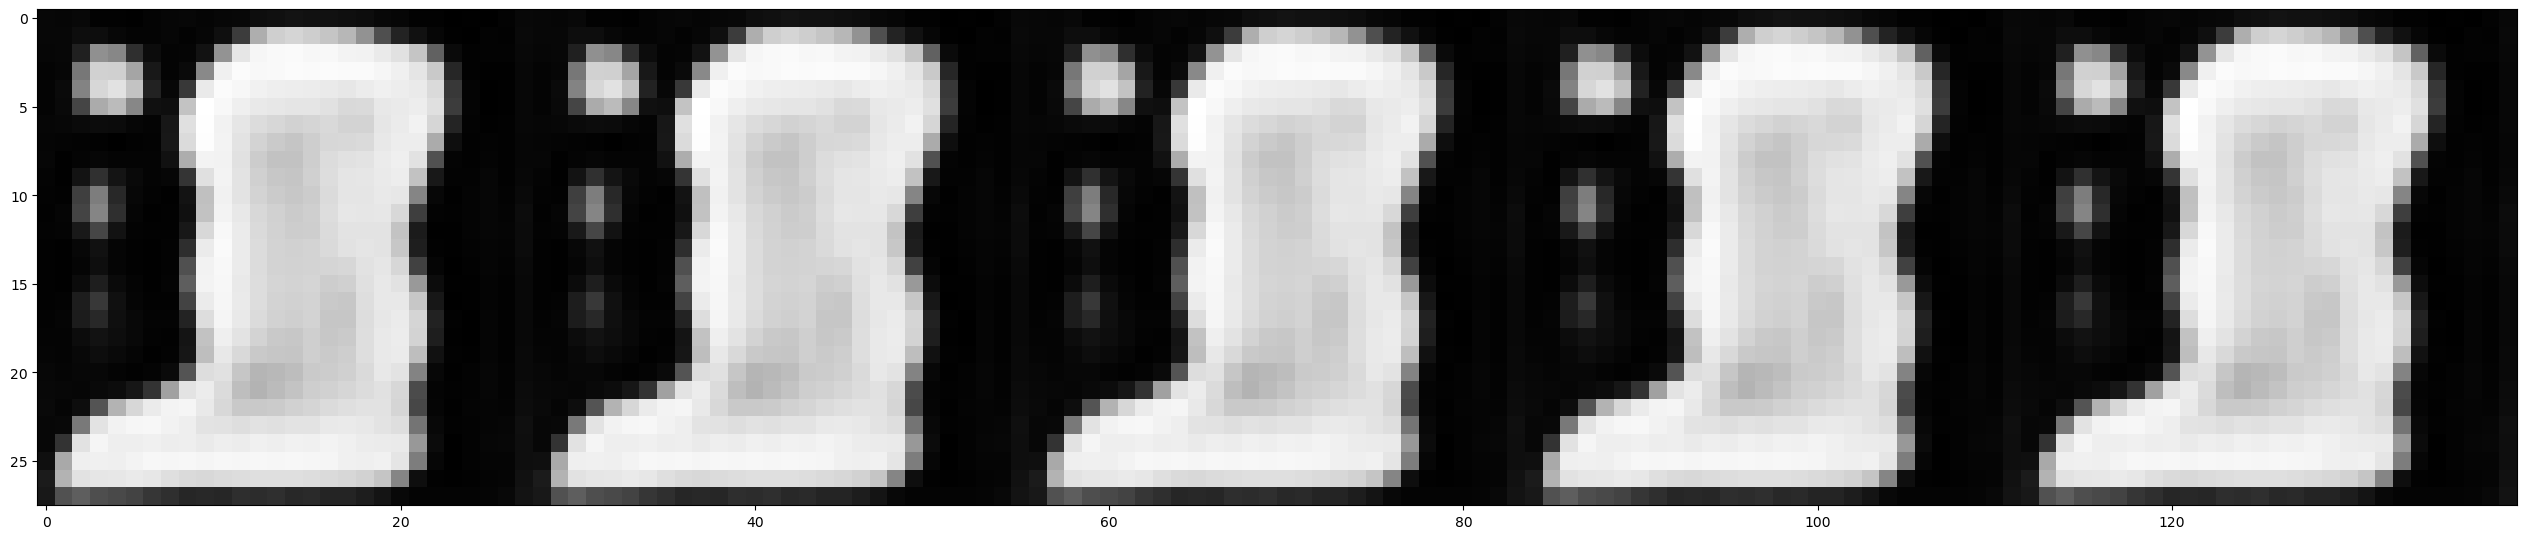

Epoch [10/100] | Train Loss: 0.0751 | Validation Loss: 0.0702
Epoch  10


100%|██████████| 750/750 [00:48<00:00, 15.45it/s]


Epoch [11/100] | Train Loss: 0.0740 | Validation Loss: 0.0722
Epoch  11


100%|██████████| 750/750 [00:48<00:00, 15.53it/s]


Epoch [12/100] | Train Loss: 0.0716 | Validation Loss: 0.0639
Epoch  12


100%|██████████| 100/100 [00:01<00:00, 59.88it/s]


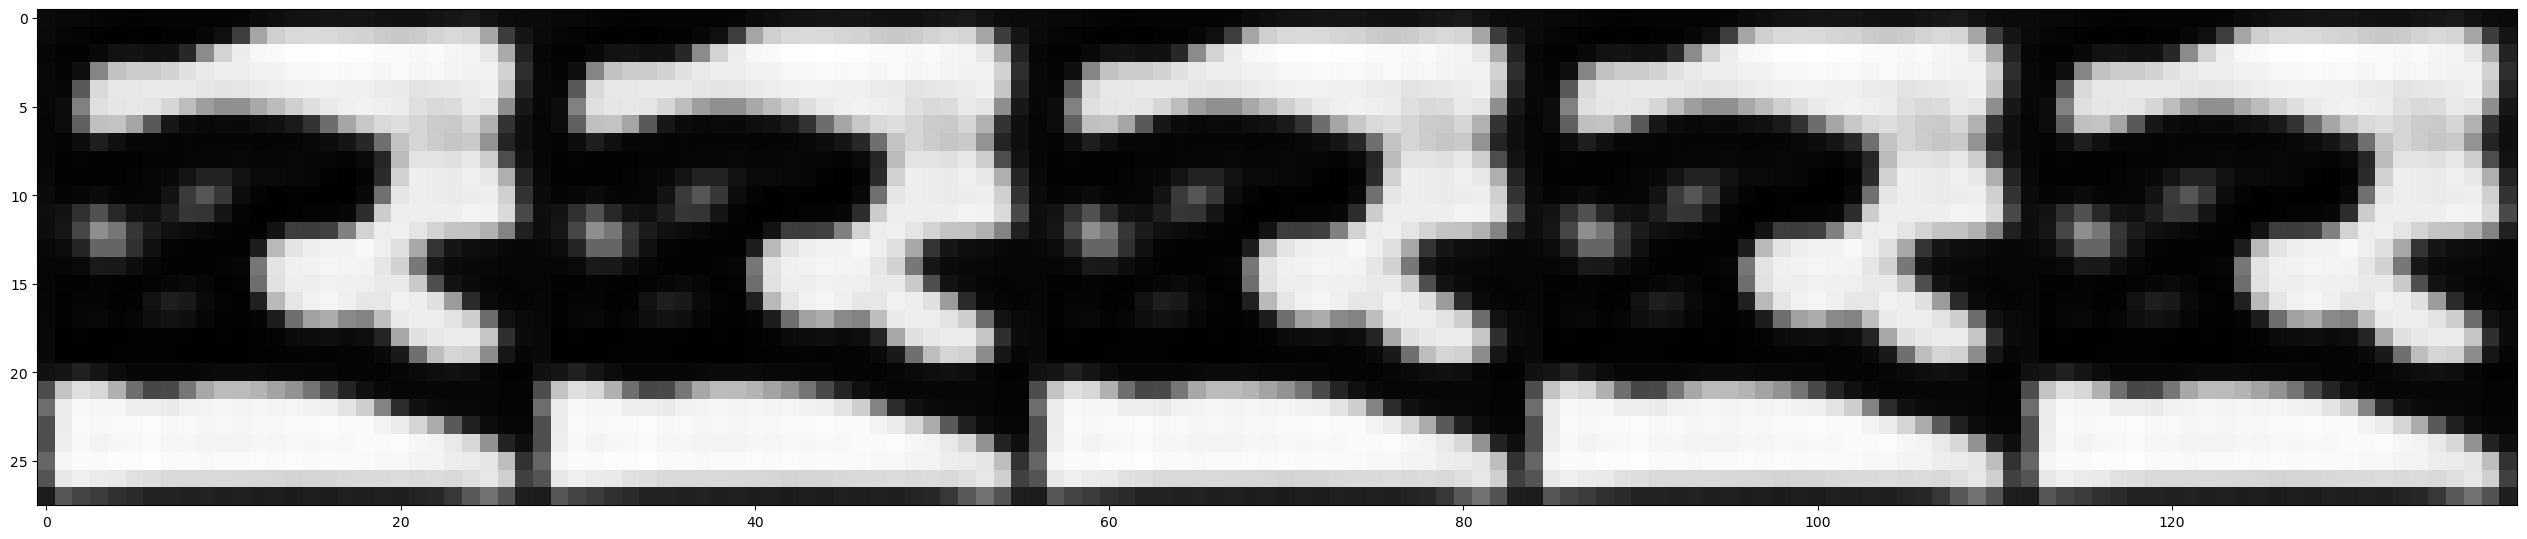

Epoch [13/100] | Train Loss: 0.0678 | Validation Loss: 0.0691
Epoch  13


100%|██████████| 750/750 [00:48<00:00, 15.42it/s]


Epoch [14/100] | Train Loss: 0.0676 | Validation Loss: 0.0681
Epoch  14


100%|██████████| 750/750 [00:48<00:00, 15.36it/s]


Epoch [15/100] | Train Loss: 0.0659 | Validation Loss: 0.0653
Epoch  15


100%|██████████| 100/100 [00:02<00:00, 49.49it/s]


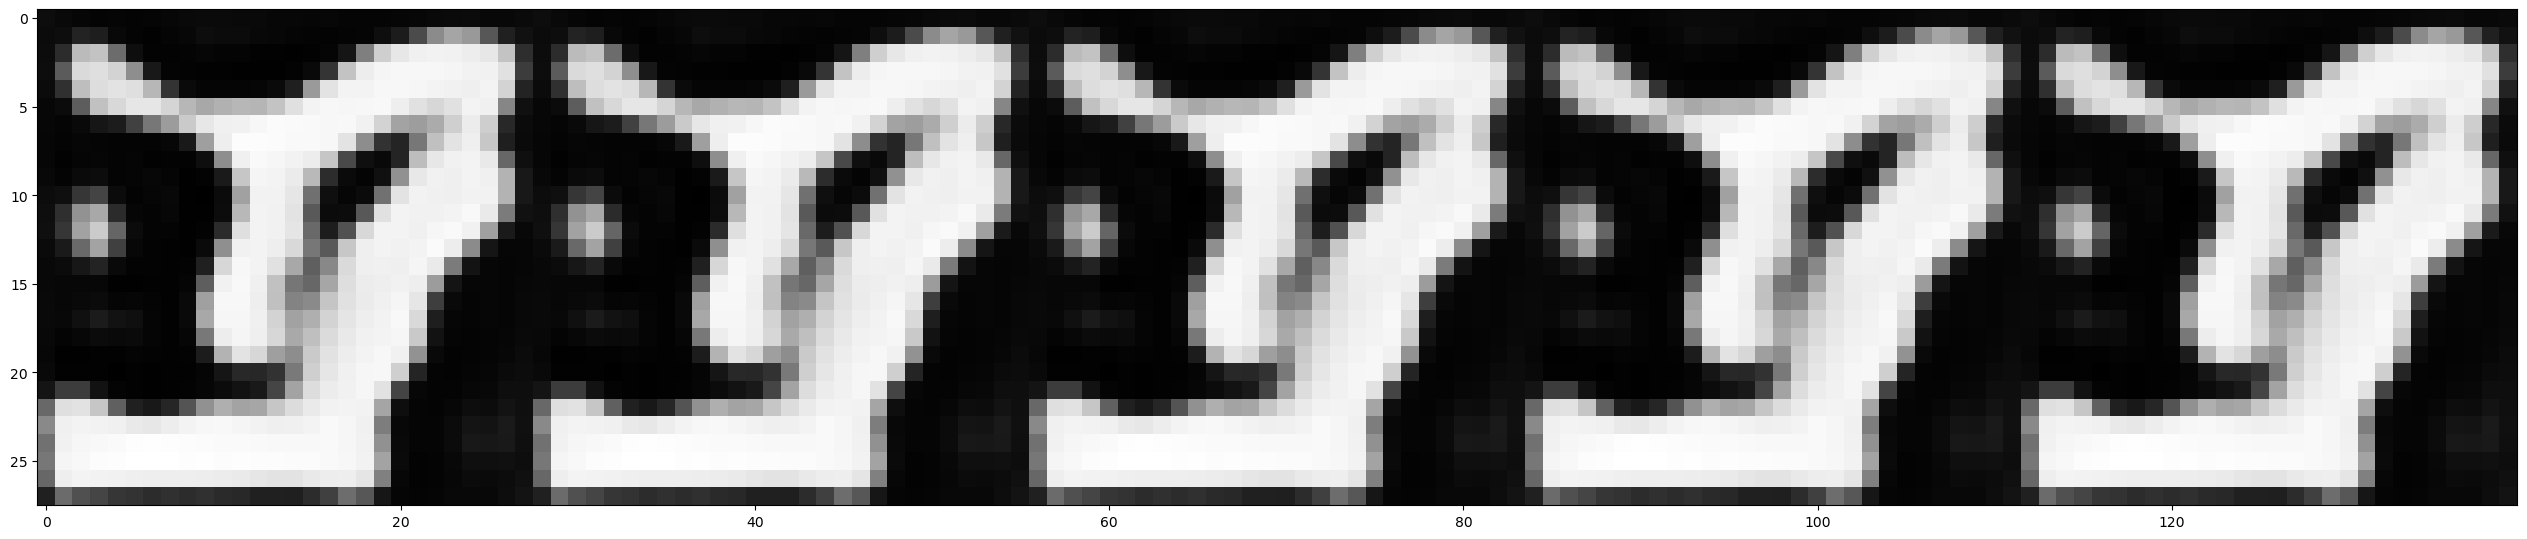

Epoch [16/100] | Train Loss: 0.0645 | Validation Loss: 0.0610
Epoch  16


100%|██████████| 750/750 [00:49<00:00, 15.23it/s]


Epoch [17/100] | Train Loss: 0.0606 | Validation Loss: 0.0726
Epoch  17


100%|██████████| 750/750 [00:49<00:00, 15.27it/s]


Epoch [18/100] | Train Loss: 0.0615 | Validation Loss: 0.0685
Epoch  18


100%|██████████| 100/100 [00:02<00:00, 49.31it/s]


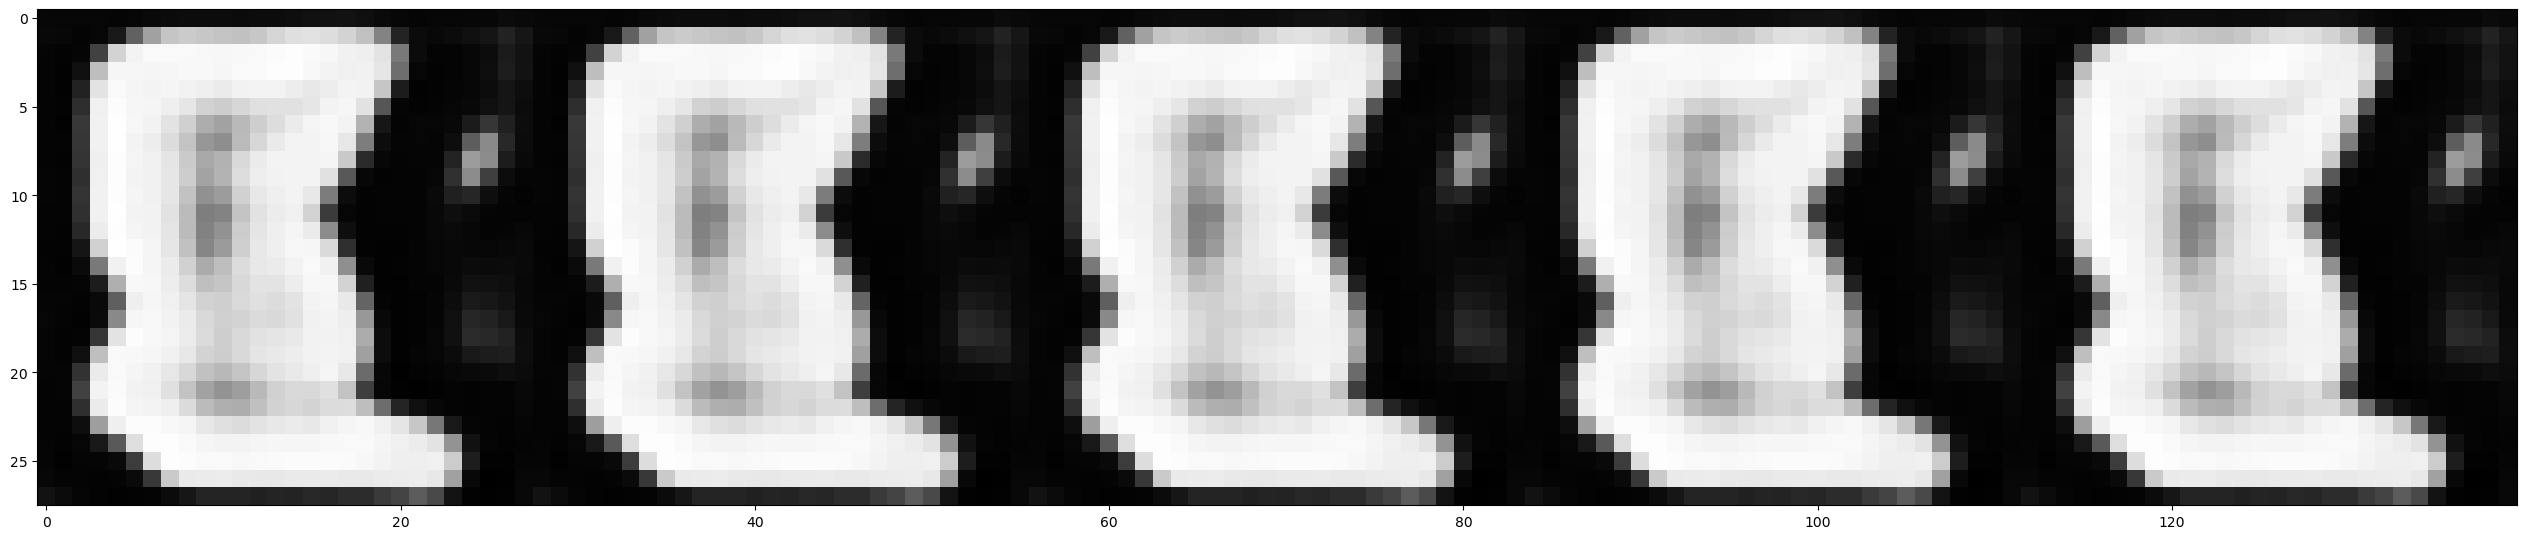

Epoch [19/100] | Train Loss: 0.0596 | Validation Loss: 0.0589
Epoch  19


100%|██████████| 750/750 [00:49<00:00, 15.15it/s]


Epoch [20/100] | Train Loss: 0.0588 | Validation Loss: 0.0566
Epoch  20


100%|██████████| 750/750 [00:48<00:00, 15.32it/s]


Epoch [21/100] | Train Loss: 0.0581 | Validation Loss: 0.0582
Epoch  21


100%|██████████| 100/100 [00:01<00:00, 55.85it/s]


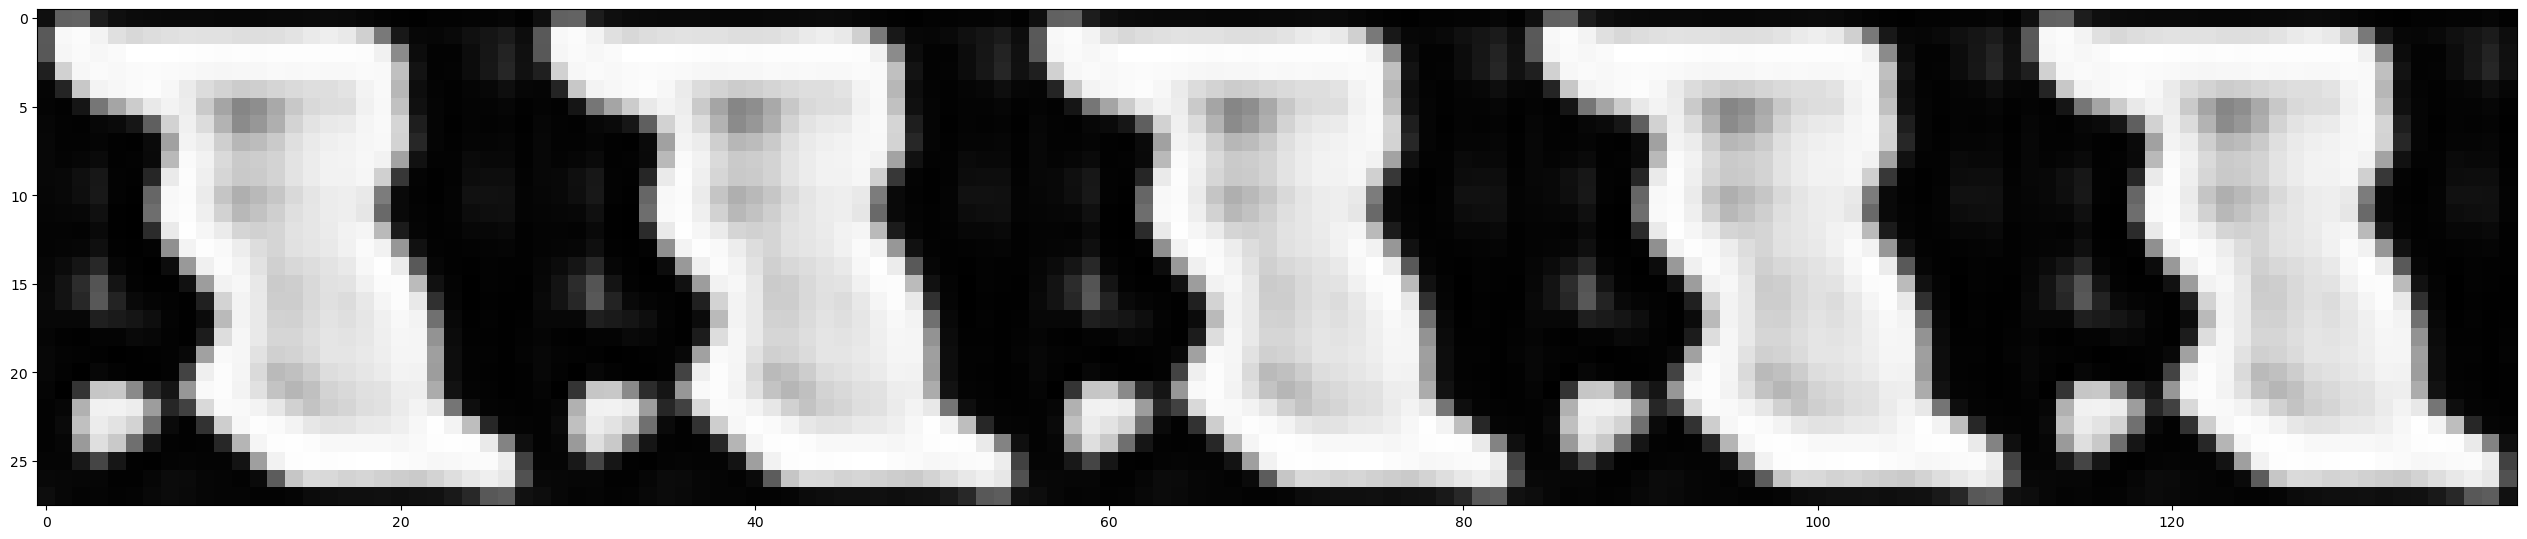

Epoch [22/100] | Train Loss: 0.0560 | Validation Loss: 0.0549
Epoch  22


100%|██████████| 750/750 [00:49<00:00, 15.30it/s]


Epoch [23/100] | Train Loss: 0.0566 | Validation Loss: 0.0526
Epoch  23


100%|██████████| 750/750 [00:49<00:00, 15.18it/s]


Epoch [24/100] | Train Loss: 0.0540 | Validation Loss: 0.0551
Epoch  24


100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


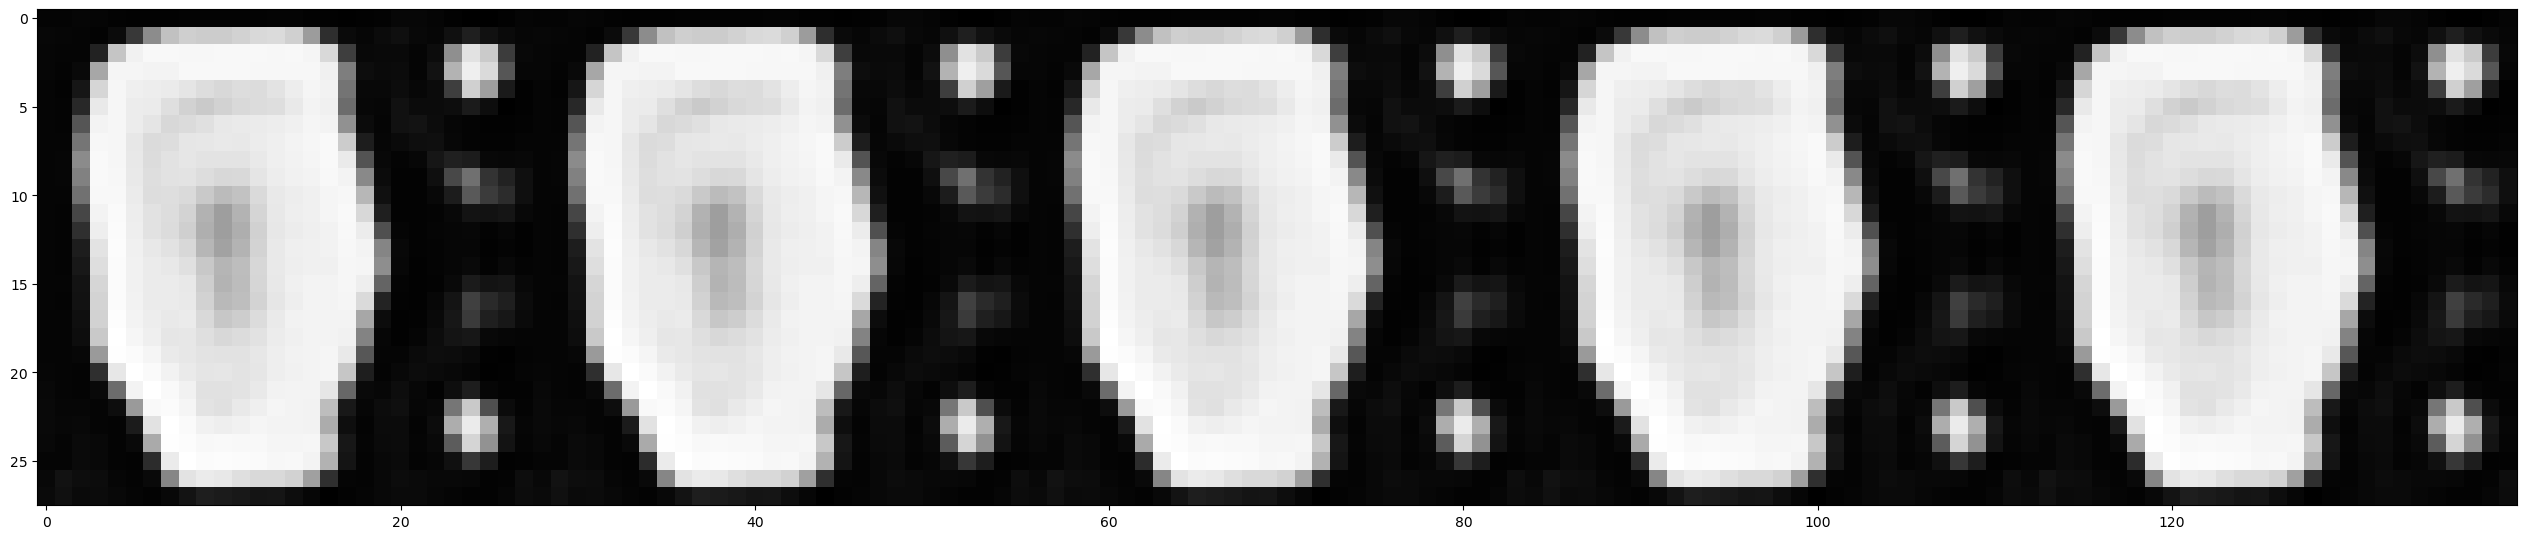

Epoch [25/100] | Train Loss: 0.0543 | Validation Loss: 0.0545
Epoch  25


100%|██████████| 750/750 [00:49<00:00, 15.10it/s]


Epoch [26/100] | Train Loss: 0.0530 | Validation Loss: 0.0487
Epoch  26


100%|██████████| 750/750 [00:49<00:00, 15.10it/s]


Epoch [27/100] | Train Loss: 0.0525 | Validation Loss: 0.0511
Epoch  27


100%|██████████| 100/100 [00:02<00:00, 41.54it/s]


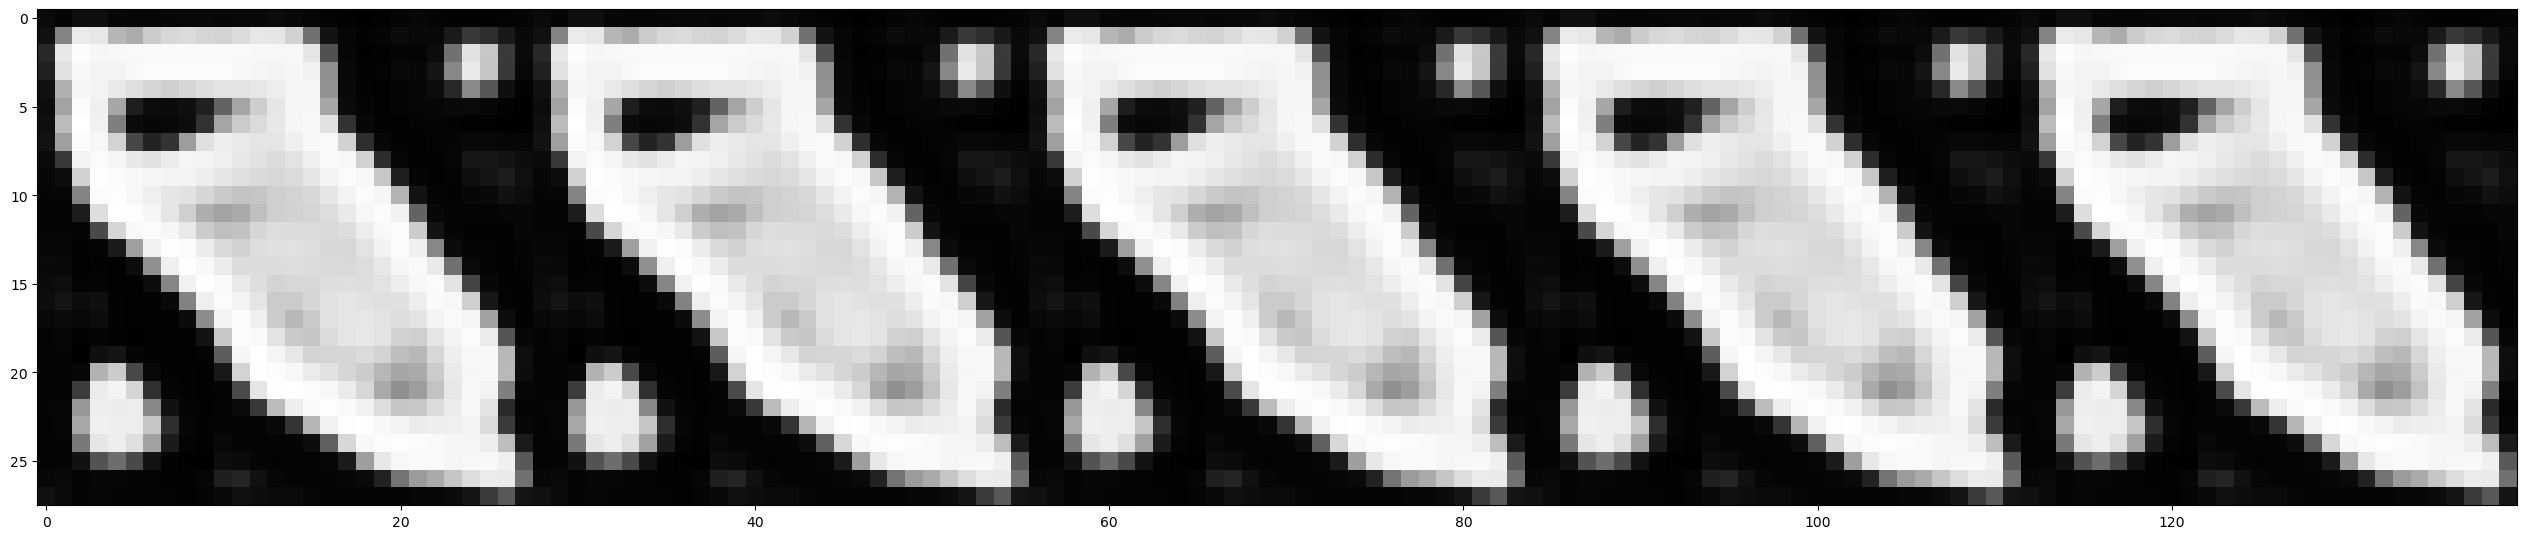

Epoch [28/100] | Train Loss: 0.0522 | Validation Loss: 0.0529
Epoch  28


100%|██████████| 750/750 [00:49<00:00, 15.19it/s]


Epoch [29/100] | Train Loss: 0.0514 | Validation Loss: 0.0468
Epoch  29


100%|██████████| 750/750 [00:49<00:00, 15.10it/s]


Epoch [30/100] | Train Loss: 0.0504 | Validation Loss: 0.0464
Epoch  30


100%|██████████| 100/100 [00:01<00:00, 55.35it/s]


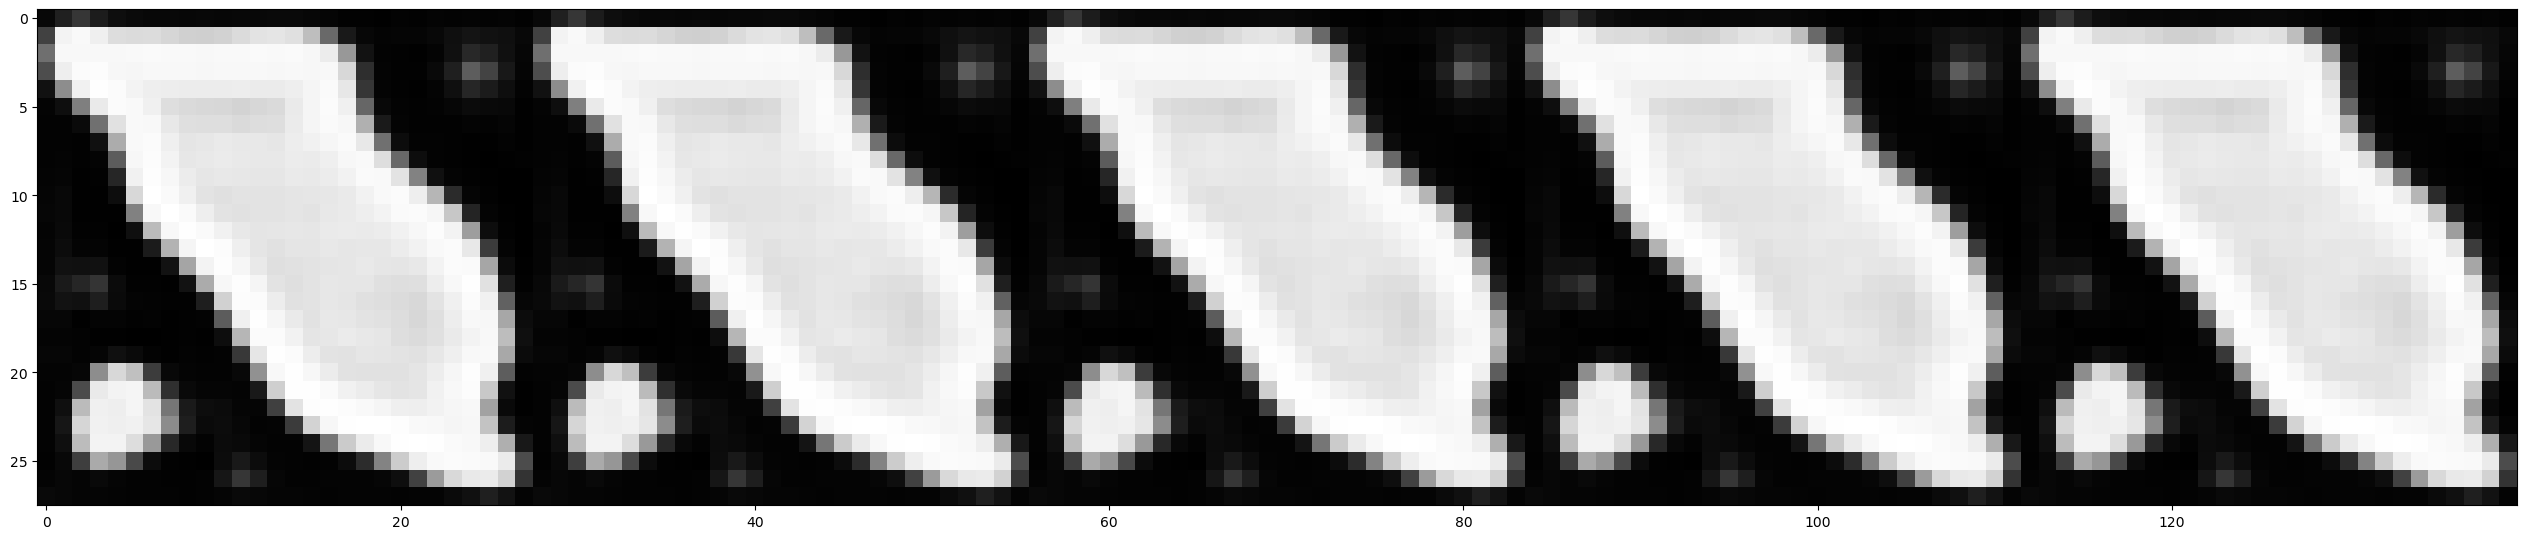

Epoch [31/100] | Train Loss: 0.0499 | Validation Loss: 0.0521
Epoch  31


100%|██████████| 750/750 [00:49<00:00, 15.02it/s]


Epoch [32/100] | Train Loss: 0.0495 | Validation Loss: 0.0503
Epoch  32


100%|██████████| 750/750 [00:49<00:00, 15.13it/s]


Epoch [33/100] | Train Loss: 0.0486 | Validation Loss: 0.0516
Epoch  33


100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


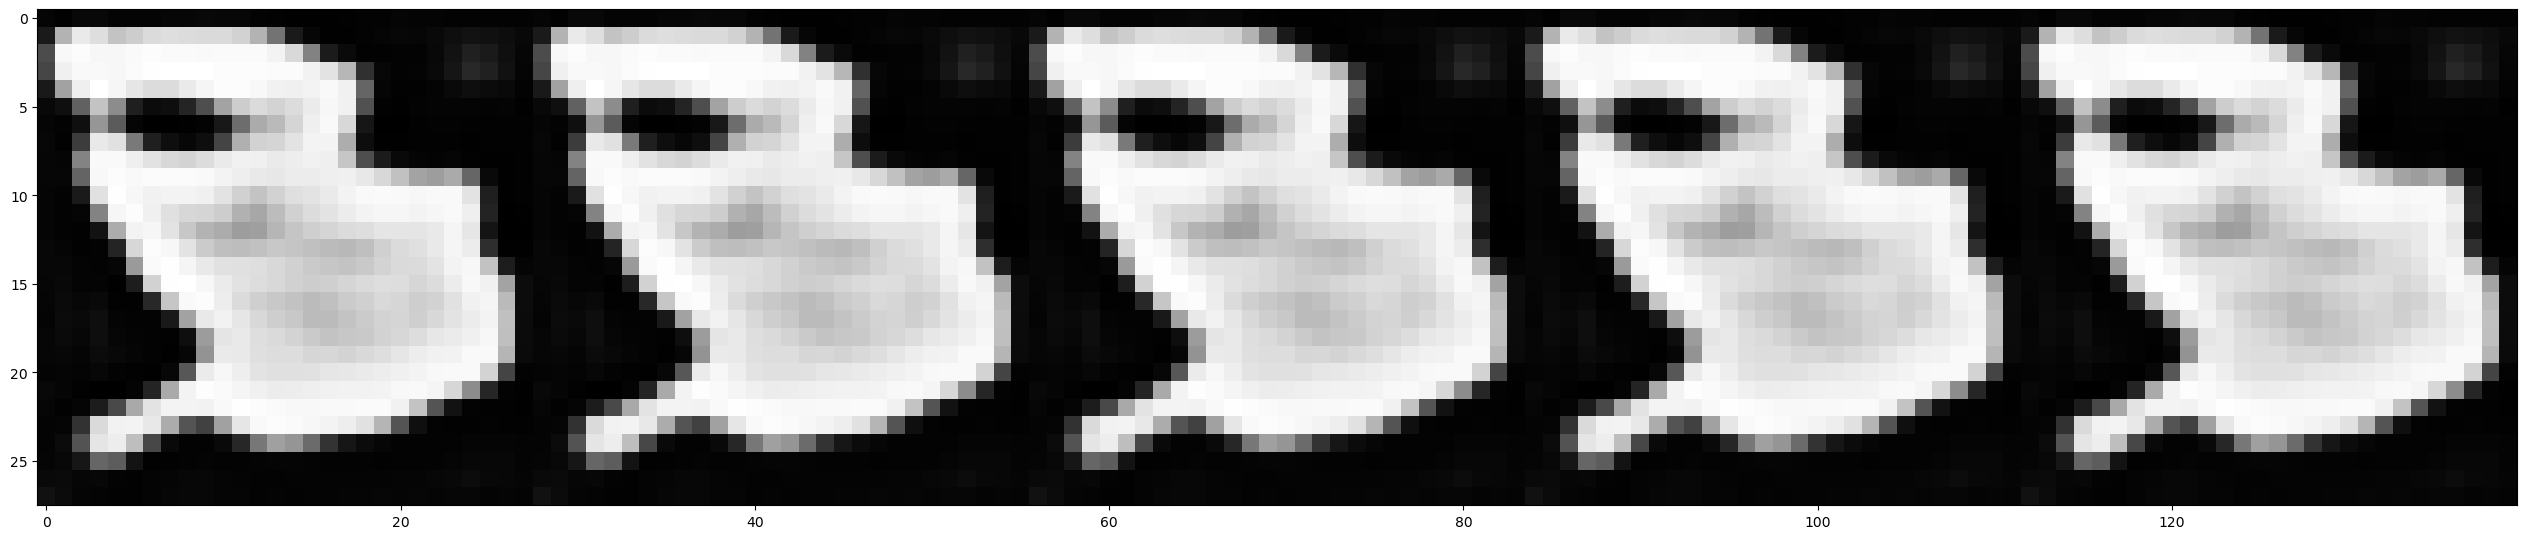

Epoch [34/100] | Train Loss: 0.0474 | Validation Loss: 0.0453
Epoch  34


100%|██████████| 750/750 [00:49<00:00, 15.15it/s]


Epoch [35/100] | Train Loss: 0.0471 | Validation Loss: 0.0462
Epoch  35


100%|██████████| 750/750 [00:49<00:00, 15.21it/s]


Epoch [36/100] | Train Loss: 0.0481 | Validation Loss: 0.0442
Epoch  36


100%|██████████| 100/100 [00:02<00:00, 49.65it/s]


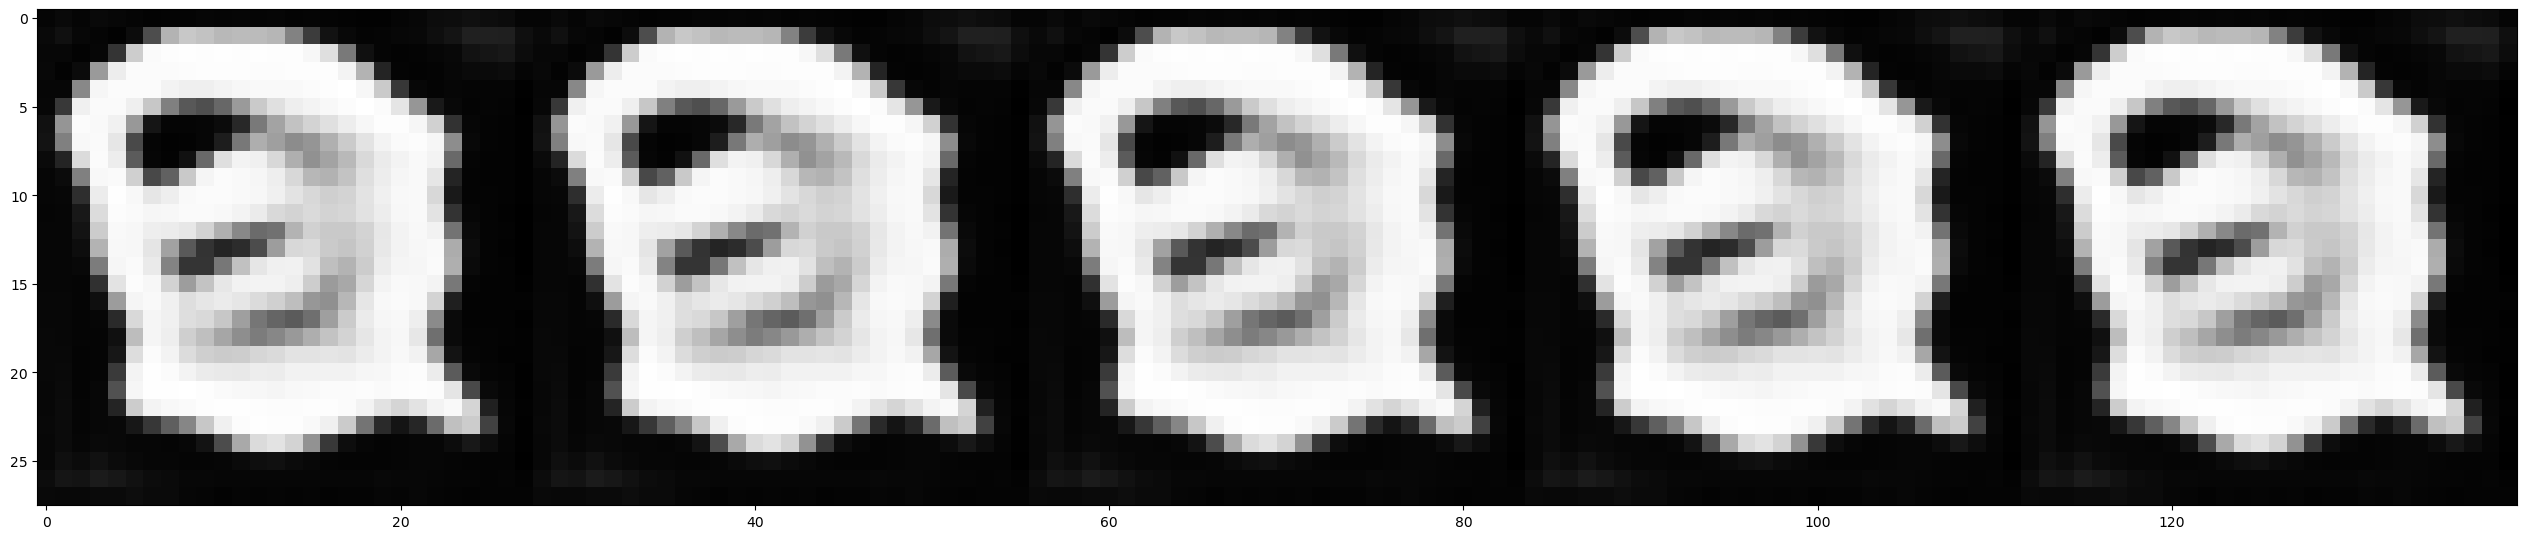

Epoch [37/100] | Train Loss: 0.0459 | Validation Loss: 0.0499
Epoch  37


100%|██████████| 750/750 [00:49<00:00, 15.19it/s]


Epoch [38/100] | Train Loss: 0.0458 | Validation Loss: 0.0442
Epoch  38


100%|██████████| 750/750 [00:49<00:00, 15.13it/s]


Epoch [39/100] | Train Loss: 0.0452 | Validation Loss: 0.0463
Epoch  39


100%|██████████| 100/100 [00:01<00:00, 55.30it/s]


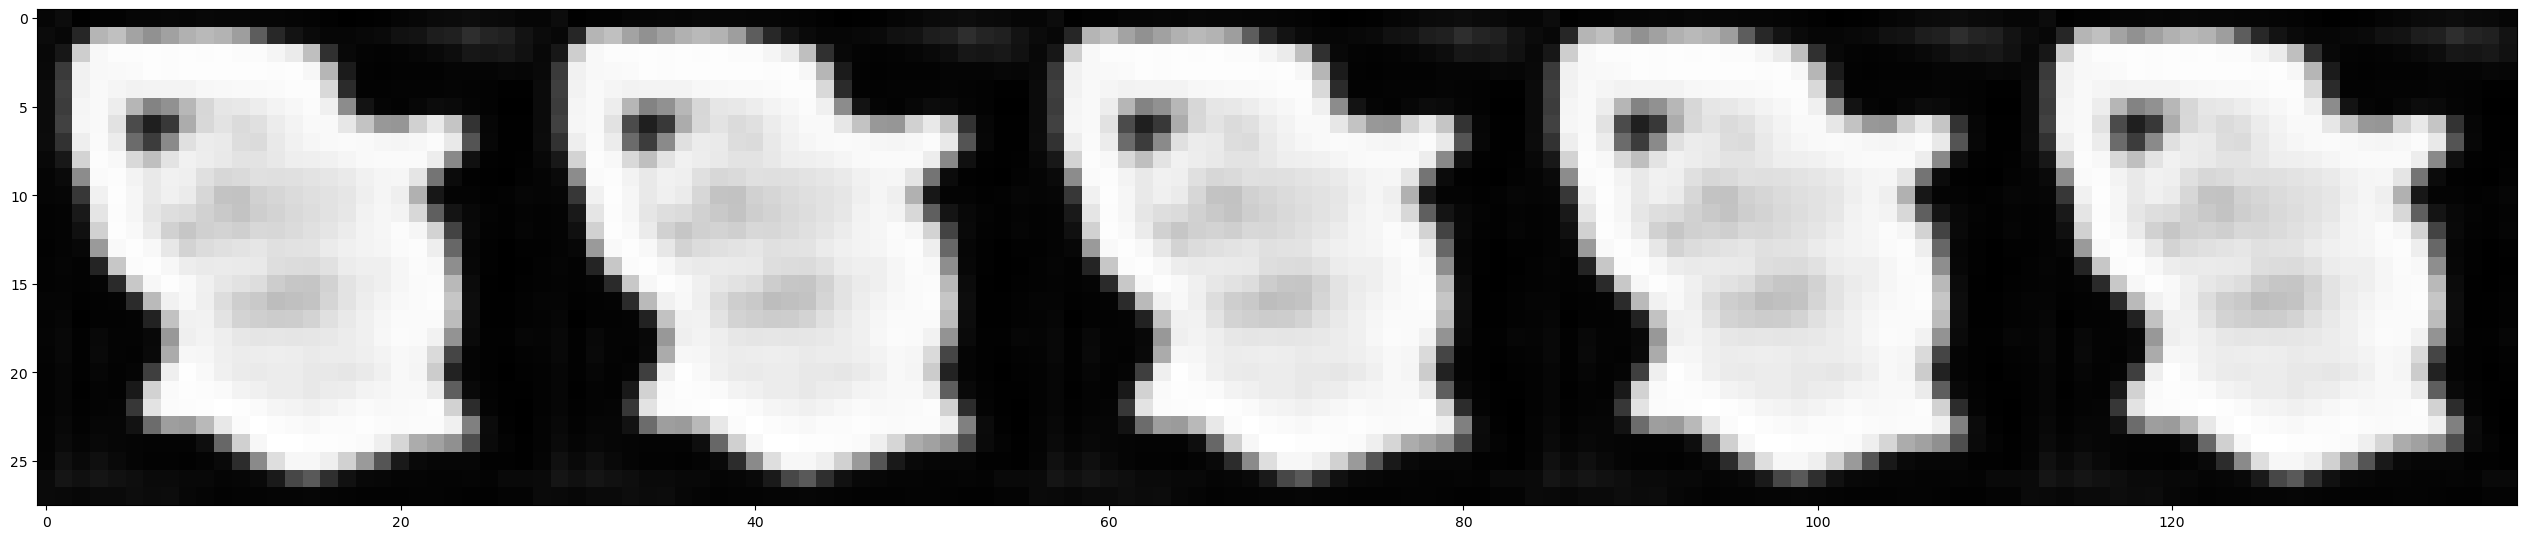

Epoch [40/100] | Train Loss: 0.0453 | Validation Loss: 0.0448
Epoch  40


100%|██████████| 750/750 [00:49<00:00, 15.16it/s]


Epoch [41/100] | Train Loss: 0.0454 | Validation Loss: 0.0433
Epoch  41


100%|██████████| 750/750 [00:49<00:00, 15.17it/s]


Epoch [42/100] | Train Loss: 0.0456 | Validation Loss: 0.0424
Epoch  42


100%|██████████| 100/100 [00:01<00:00, 55.78it/s]


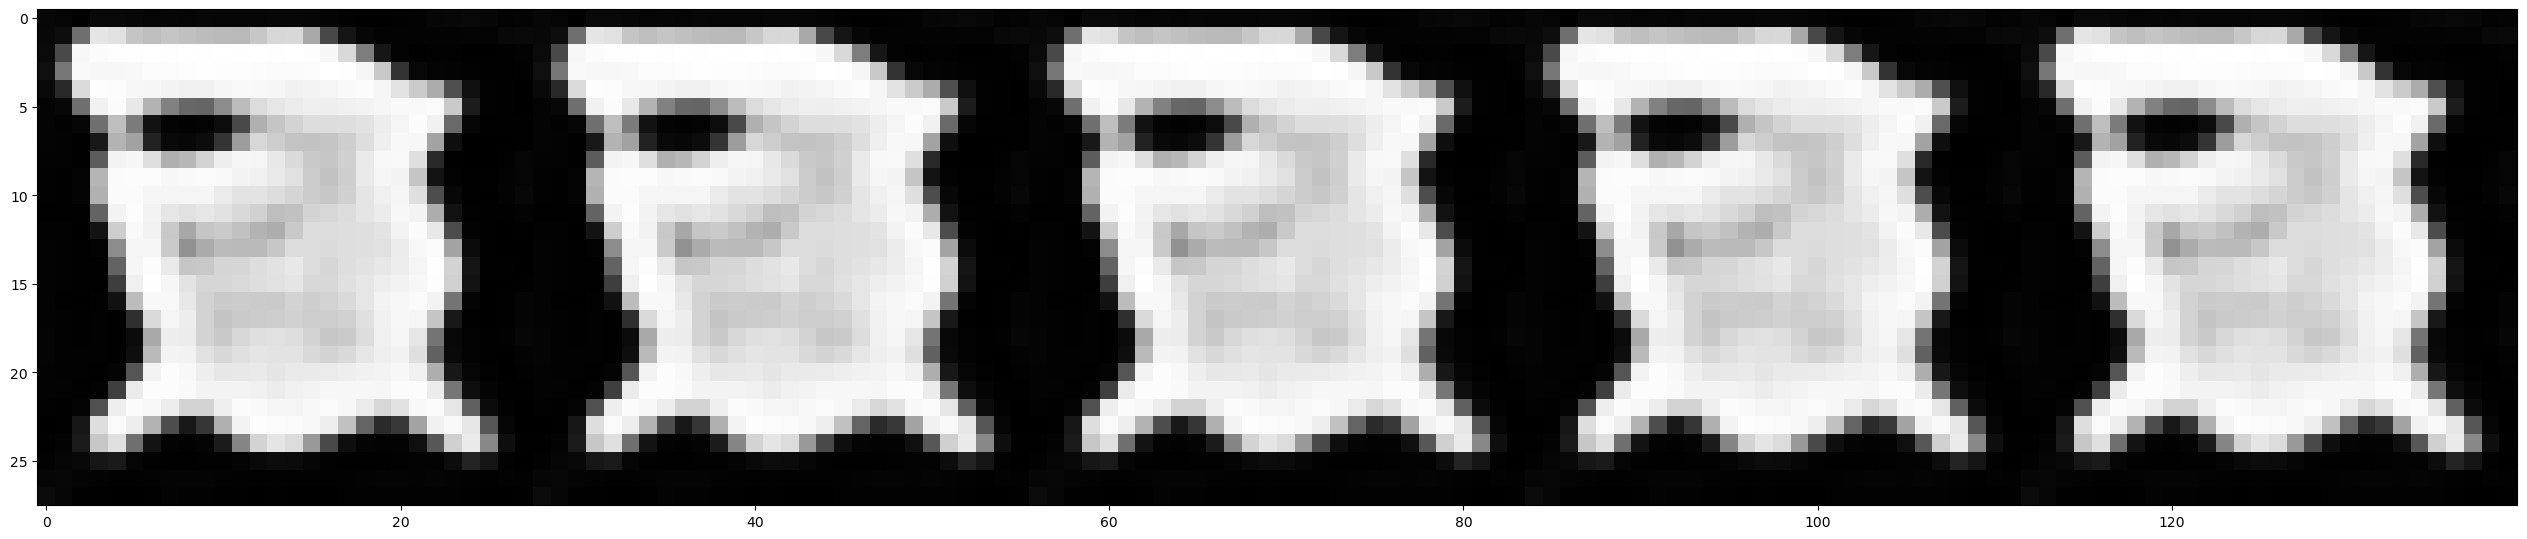

Epoch [43/100] | Train Loss: 0.0445 | Validation Loss: 0.0444
Epoch  43


100%|██████████| 750/750 [00:49<00:00, 15.21it/s]


Epoch [44/100] | Train Loss: 0.0438 | Validation Loss: 0.0437
Epoch  44


100%|██████████| 750/750 [00:49<00:00, 15.01it/s]


Epoch [45/100] | Train Loss: 0.0431 | Validation Loss: 0.0399
Epoch  45


100%|██████████| 100/100 [00:02<00:00, 41.56it/s]


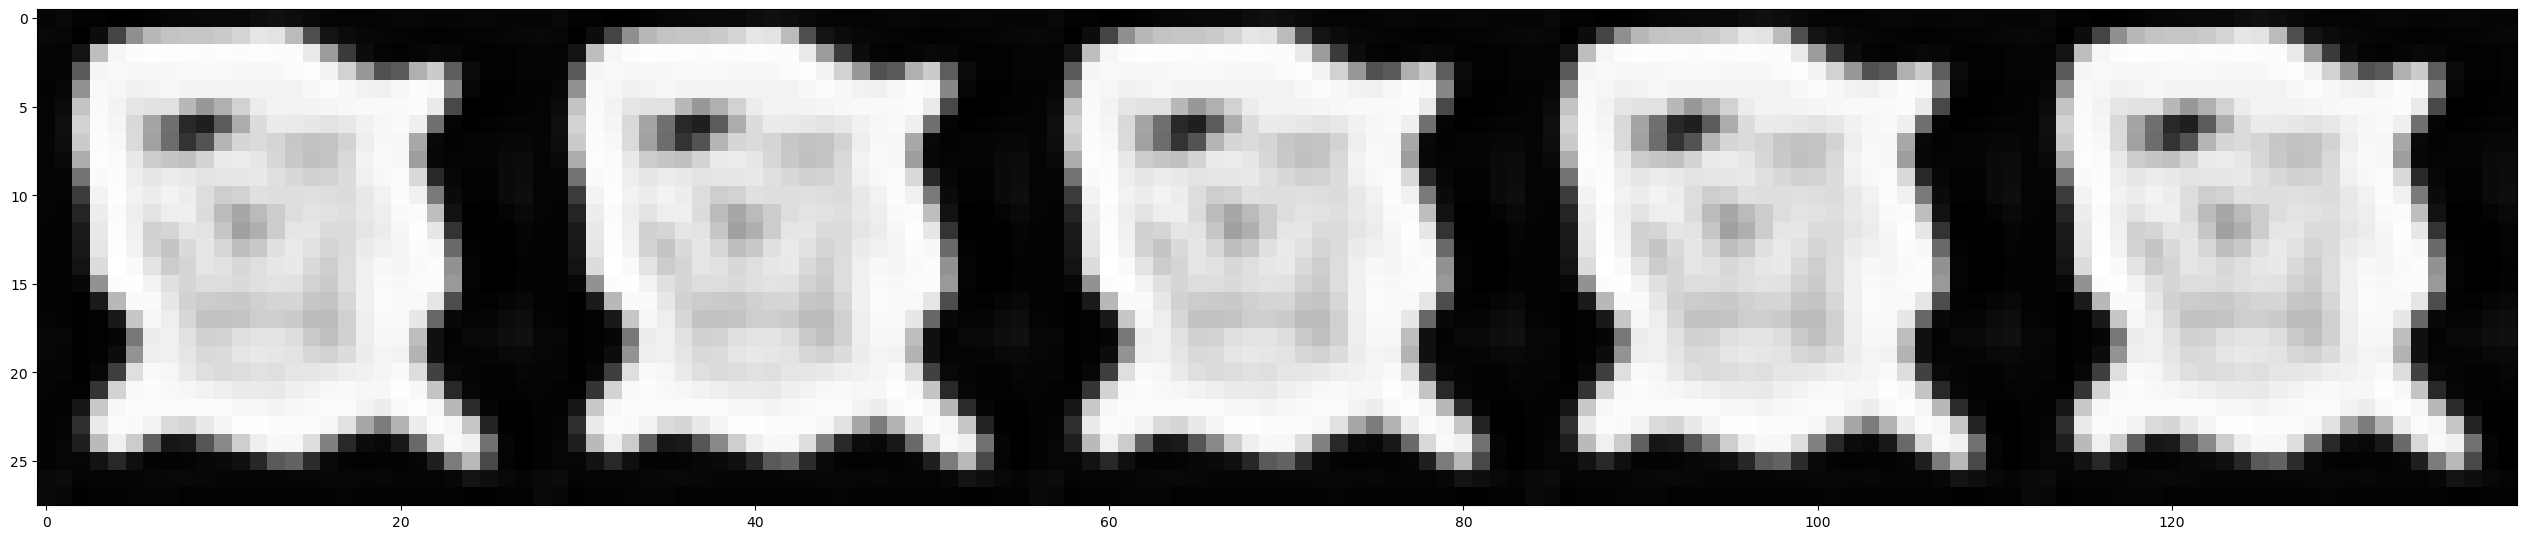

Epoch [46/100] | Train Loss: 0.0434 | Validation Loss: 0.0413
Epoch  46


100%|██████████| 750/750 [00:50<00:00, 14.84it/s]


Epoch [47/100] | Train Loss: 0.0431 | Validation Loss: 0.0432
Epoch  47


100%|██████████| 750/750 [00:50<00:00, 14.98it/s]


Epoch [48/100] | Train Loss: 0.0416 | Validation Loss: 0.0483
Epoch  48


100%|██████████| 100/100 [00:02<00:00, 48.17it/s]


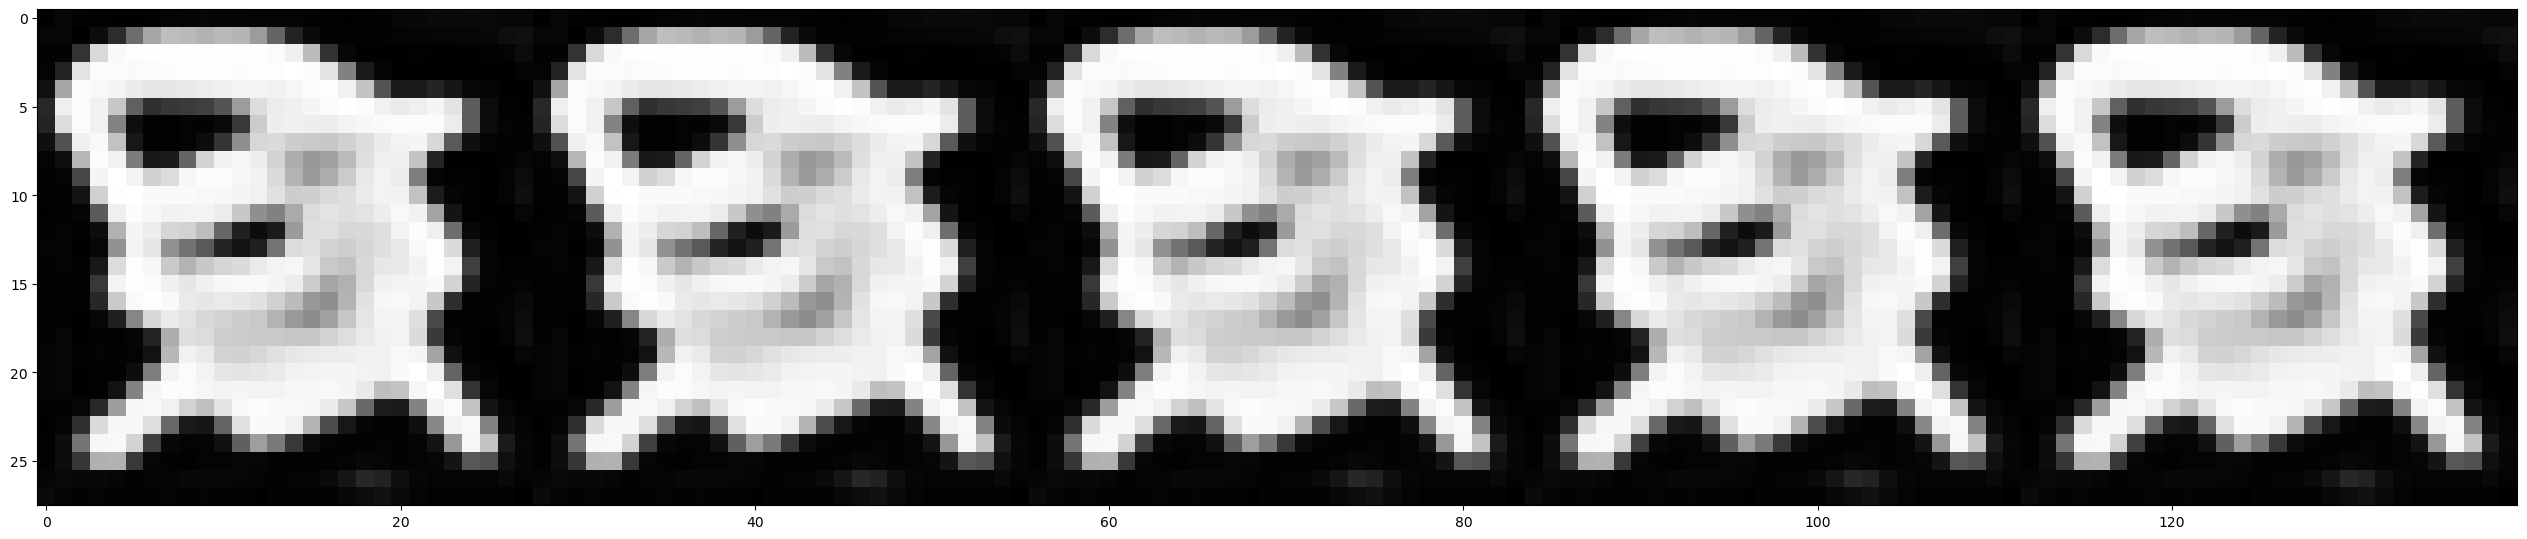

Epoch [49/100] | Train Loss: 0.0425 | Validation Loss: 0.0429
Epoch  49


100%|██████████| 750/750 [00:50<00:00, 14.92it/s]


Epoch [50/100] | Train Loss: 0.0412 | Validation Loss: 0.0396
Epoch  50


100%|██████████| 750/750 [00:50<00:00, 14.85it/s]


Epoch [51/100] | Train Loss: 0.0414 | Validation Loss: 0.0413
Epoch  51


100%|██████████| 100/100 [00:01<00:00, 54.50it/s]


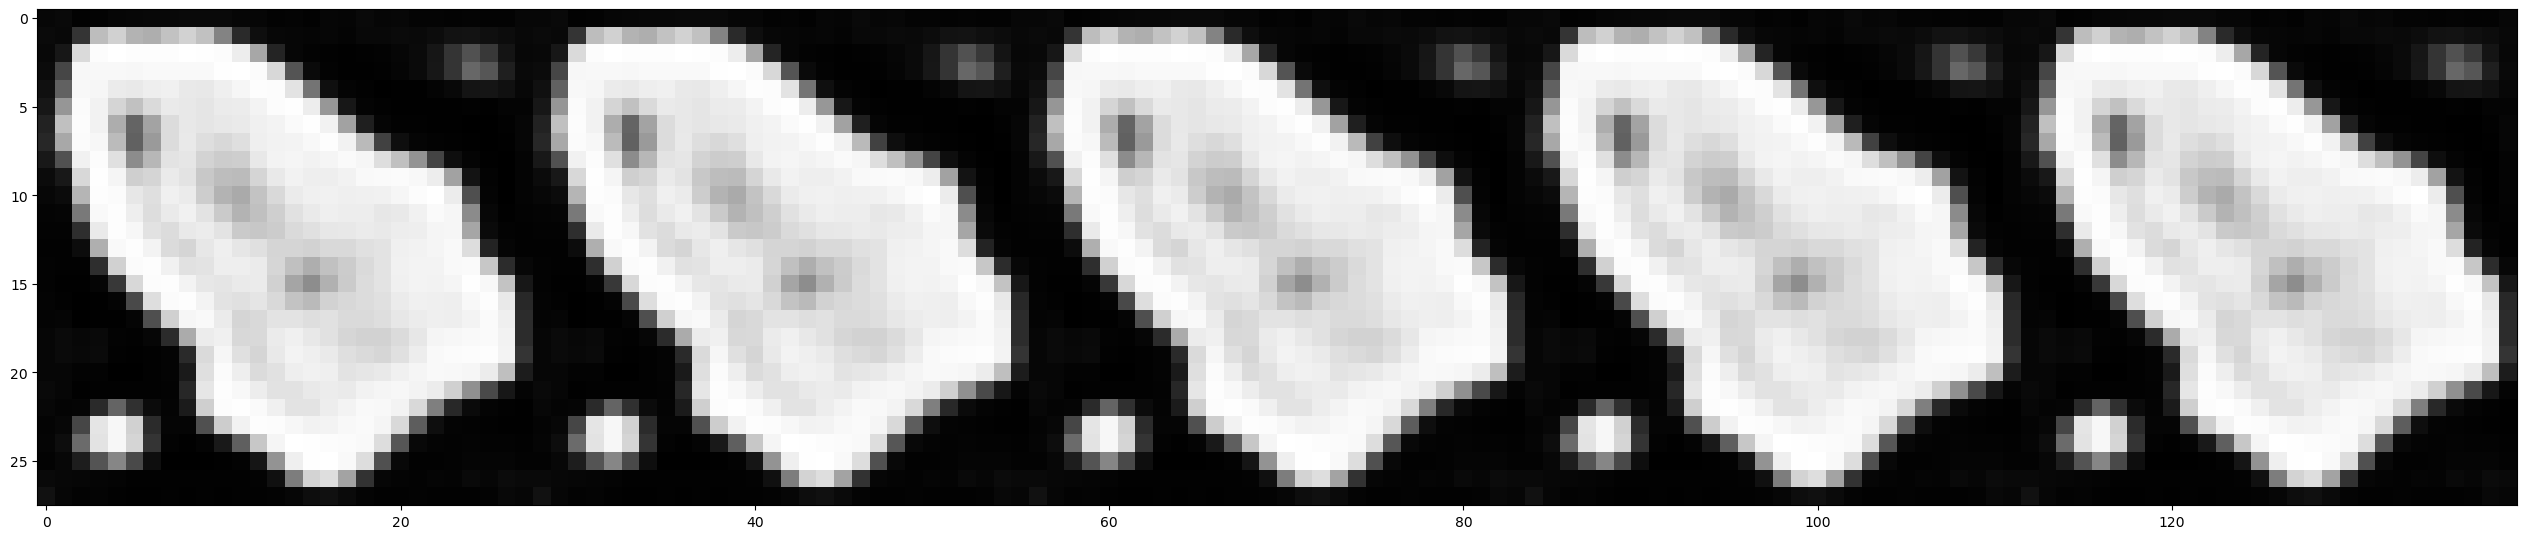

Epoch [52/100] | Train Loss: 0.0416 | Validation Loss: 0.0397
Epoch  52


100%|██████████| 750/750 [00:50<00:00, 14.79it/s]


Epoch [53/100] | Train Loss: 0.0410 | Validation Loss: 0.0361
Epoch  53


100%|██████████| 750/750 [00:50<00:00, 14.88it/s]


Epoch [54/100] | Train Loss: 0.0405 | Validation Loss: 0.0394
Epoch  54


100%|██████████| 100/100 [00:02<00:00, 43.69it/s]


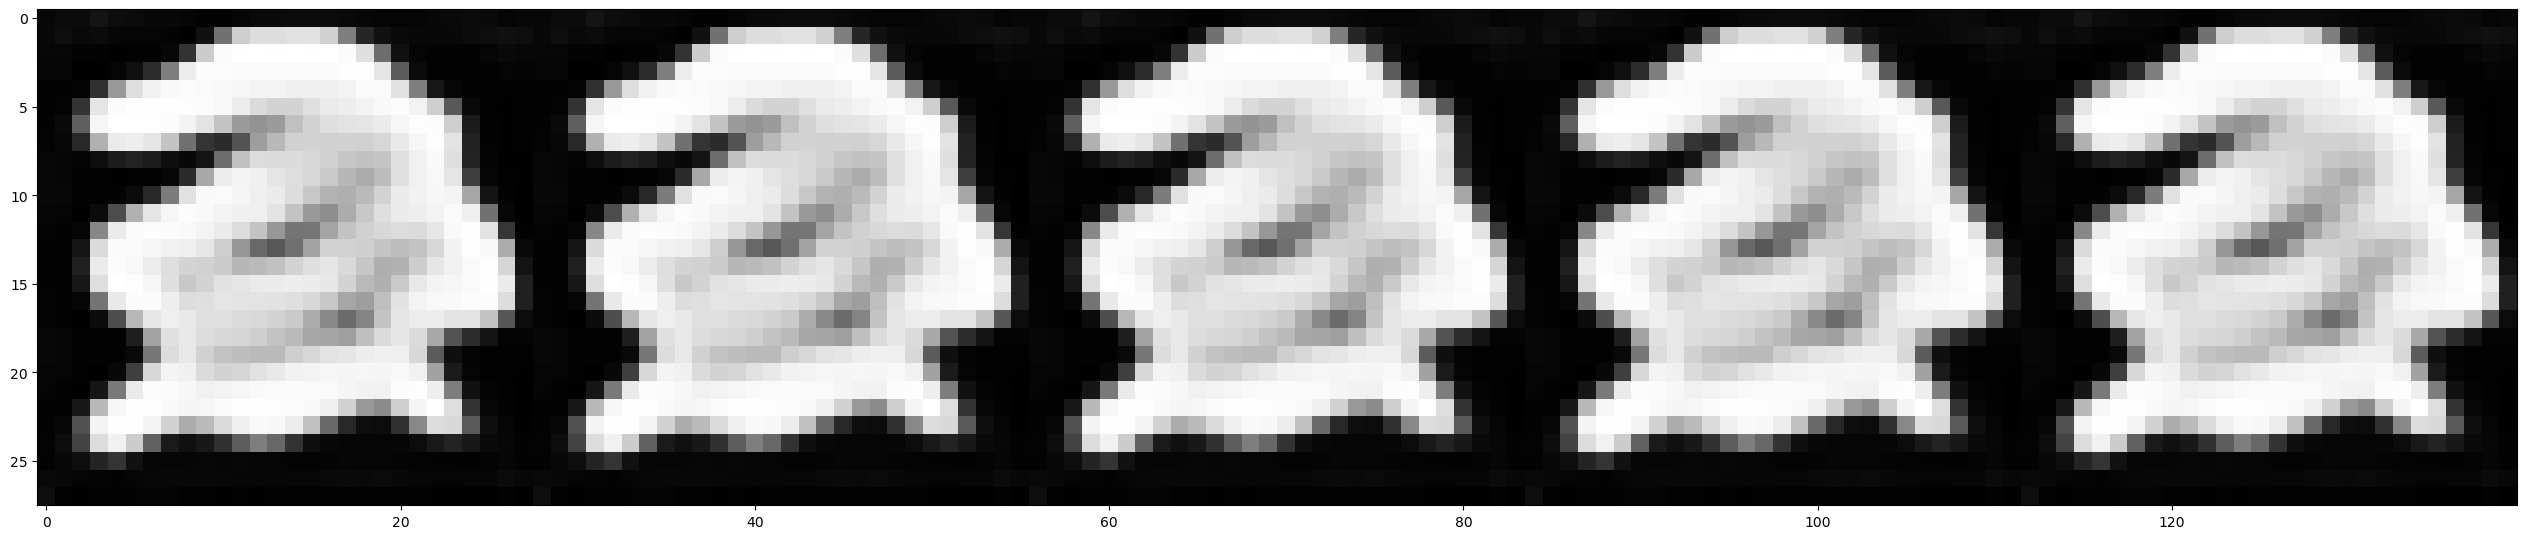

Epoch [55/100] | Train Loss: 0.0400 | Validation Loss: 0.0381
Epoch  55


100%|██████████| 750/750 [00:50<00:00, 14.92it/s]


Epoch [56/100] | Train Loss: 0.0396 | Validation Loss: 0.0448
Epoch  56


100%|██████████| 750/750 [00:50<00:00, 14.98it/s]


Epoch [57/100] | Train Loss: 0.0396 | Validation Loss: 0.0425
Epoch  57


100%|██████████| 100/100 [00:02<00:00, 47.25it/s]


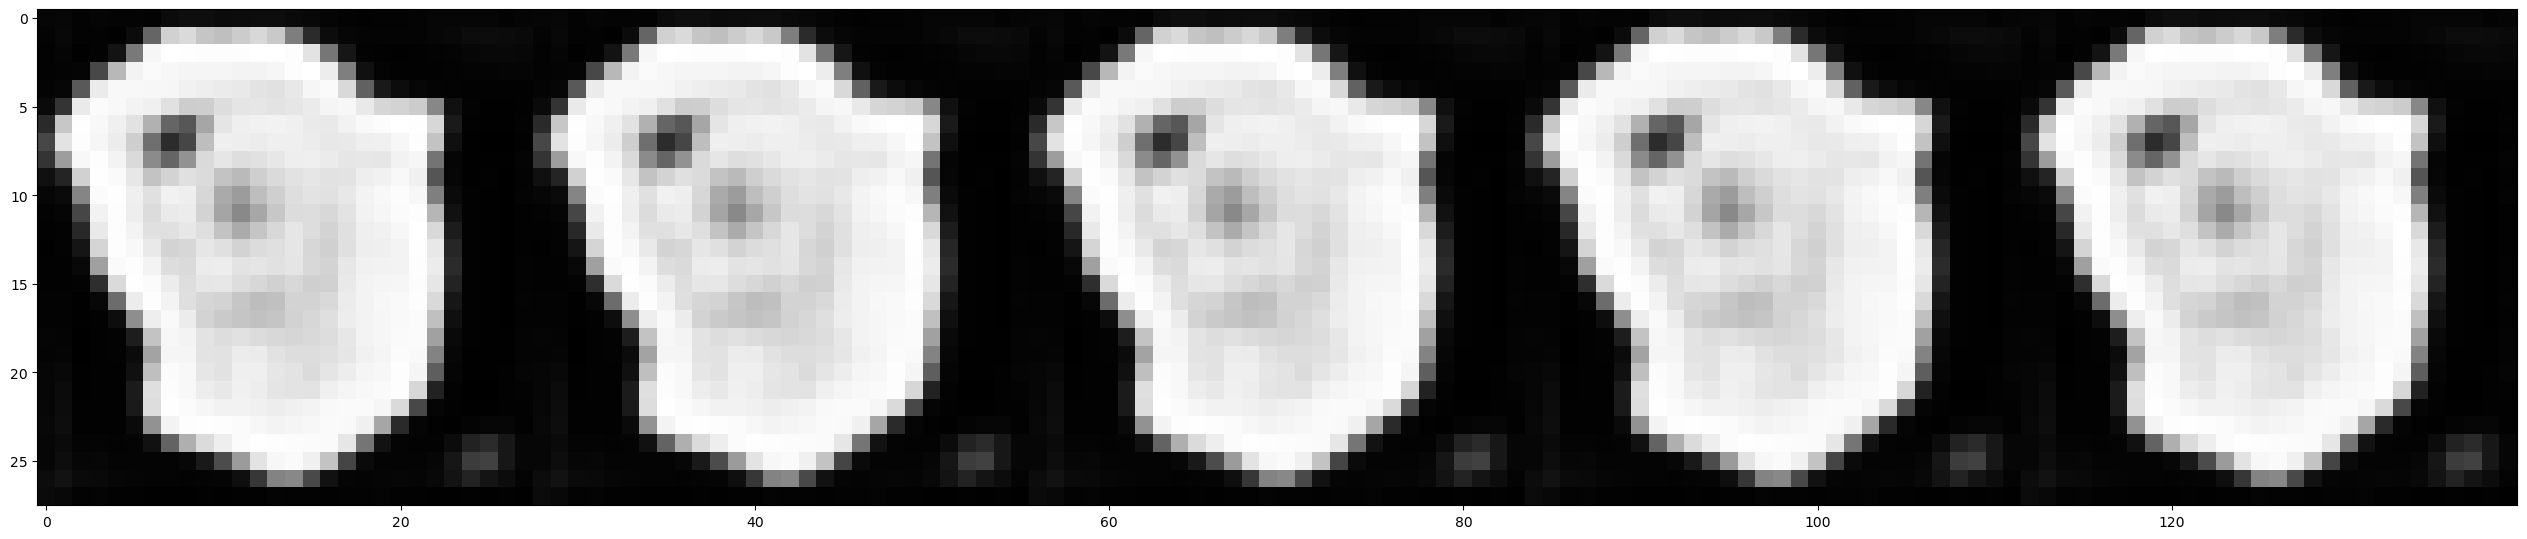

Epoch [58/100] | Train Loss: 0.0389 | Validation Loss: 0.0360
Epoch  58


100%|██████████| 750/750 [00:50<00:00, 14.83it/s]


Epoch [59/100] | Train Loss: 0.0401 | Validation Loss: 0.0371
Epoch  59


100%|██████████| 750/750 [00:50<00:00, 14.93it/s]


Epoch [60/100] | Train Loss: 0.0387 | Validation Loss: 0.0340
Epoch  60


100%|██████████| 100/100 [00:02<00:00, 43.55it/s]


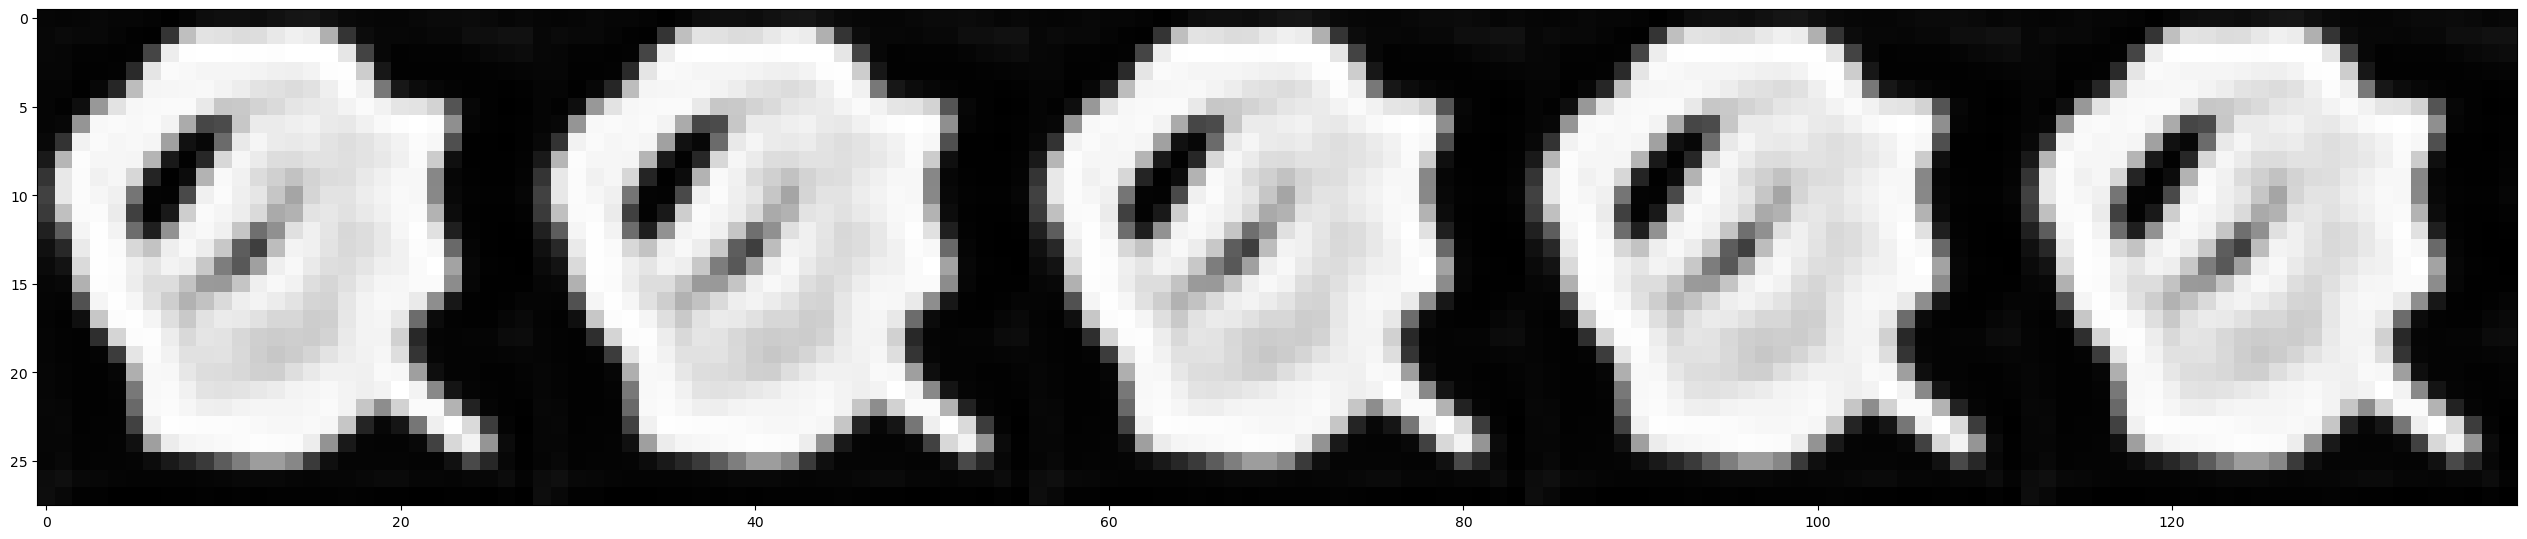

Epoch [61/100] | Train Loss: 0.0370 | Validation Loss: 0.0356
Epoch  61


100%|██████████| 750/750 [00:49<00:00, 15.06it/s]


Epoch [62/100] | Train Loss: 0.0371 | Validation Loss: 0.0593
Epoch  62


100%|██████████| 750/750 [00:50<00:00, 14.78it/s]


Epoch [63/100] | Train Loss: 0.0378 | Validation Loss: 0.0358
Epoch  63


100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


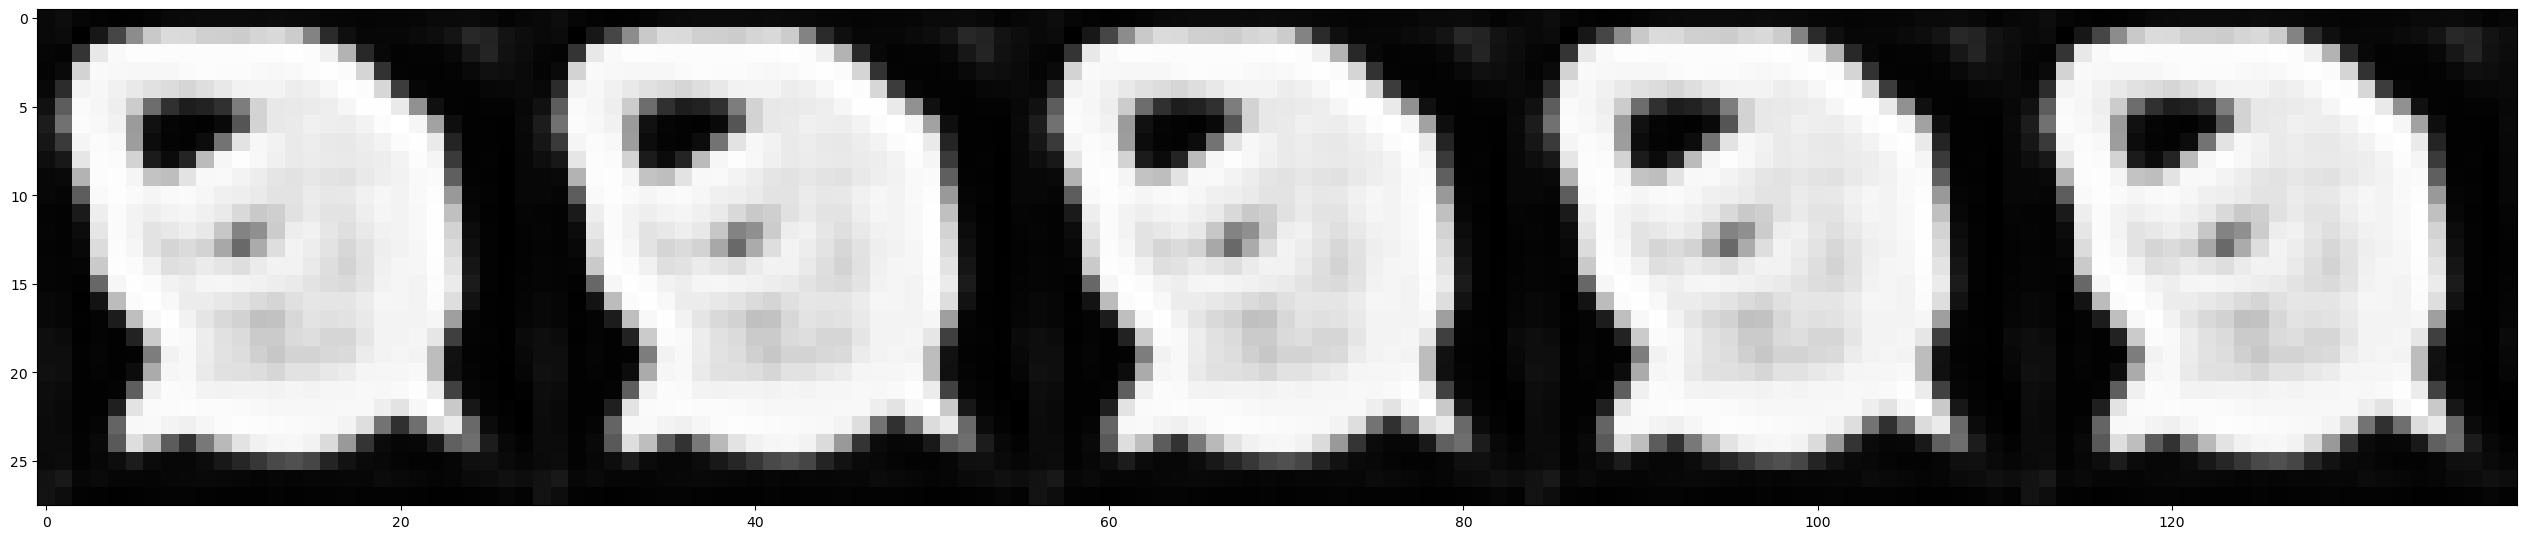

Epoch [64/100] | Train Loss: 0.0373 | Validation Loss: 0.0362
Epoch  64


100%|██████████| 750/750 [00:50<00:00, 14.71it/s]


Epoch [65/100] | Train Loss: 0.0381 | Validation Loss: 0.0360
Epoch  65


100%|██████████| 750/750 [00:49<00:00, 15.10it/s]


Epoch [66/100] | Train Loss: 0.0368 | Validation Loss: 0.0329
Epoch  66


100%|██████████| 100/100 [00:02<00:00, 49.07it/s]


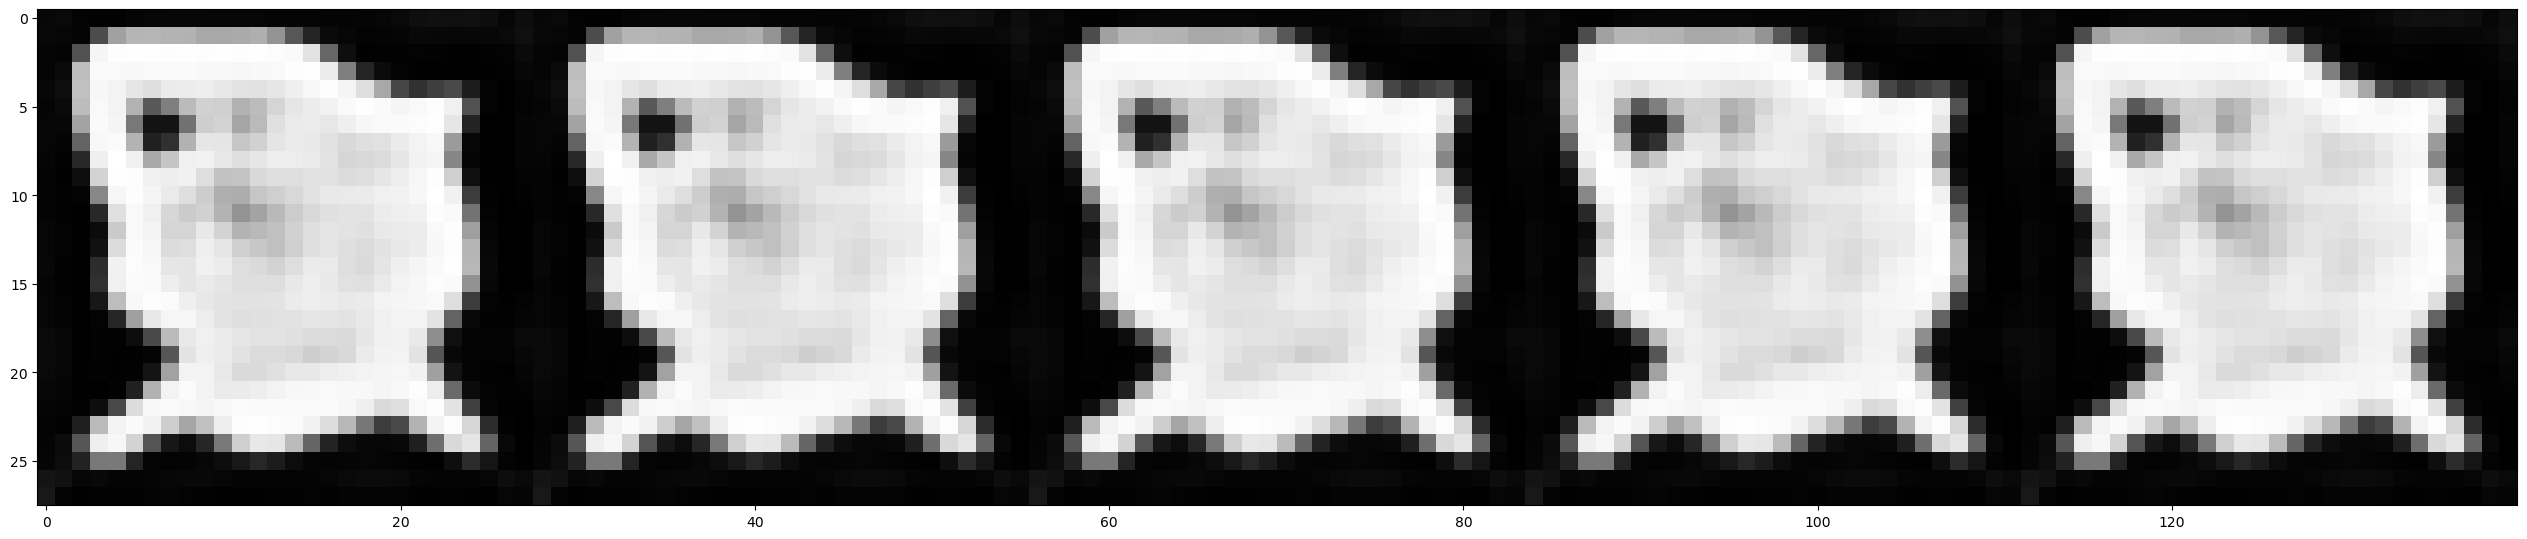

Epoch [67/100] | Train Loss: 0.0354 | Validation Loss: 0.0334
Epoch  67


100%|██████████| 750/750 [00:50<00:00, 14.91it/s]


Epoch [68/100] | Train Loss: 0.0357 | Validation Loss: 0.0319
Epoch  68


100%|██████████| 750/750 [00:50<00:00, 14.86it/s]


Epoch [69/100] | Train Loss: 0.0358 | Validation Loss: 0.0355
Epoch  69


100%|██████████| 100/100 [00:01<00:00, 54.84it/s]


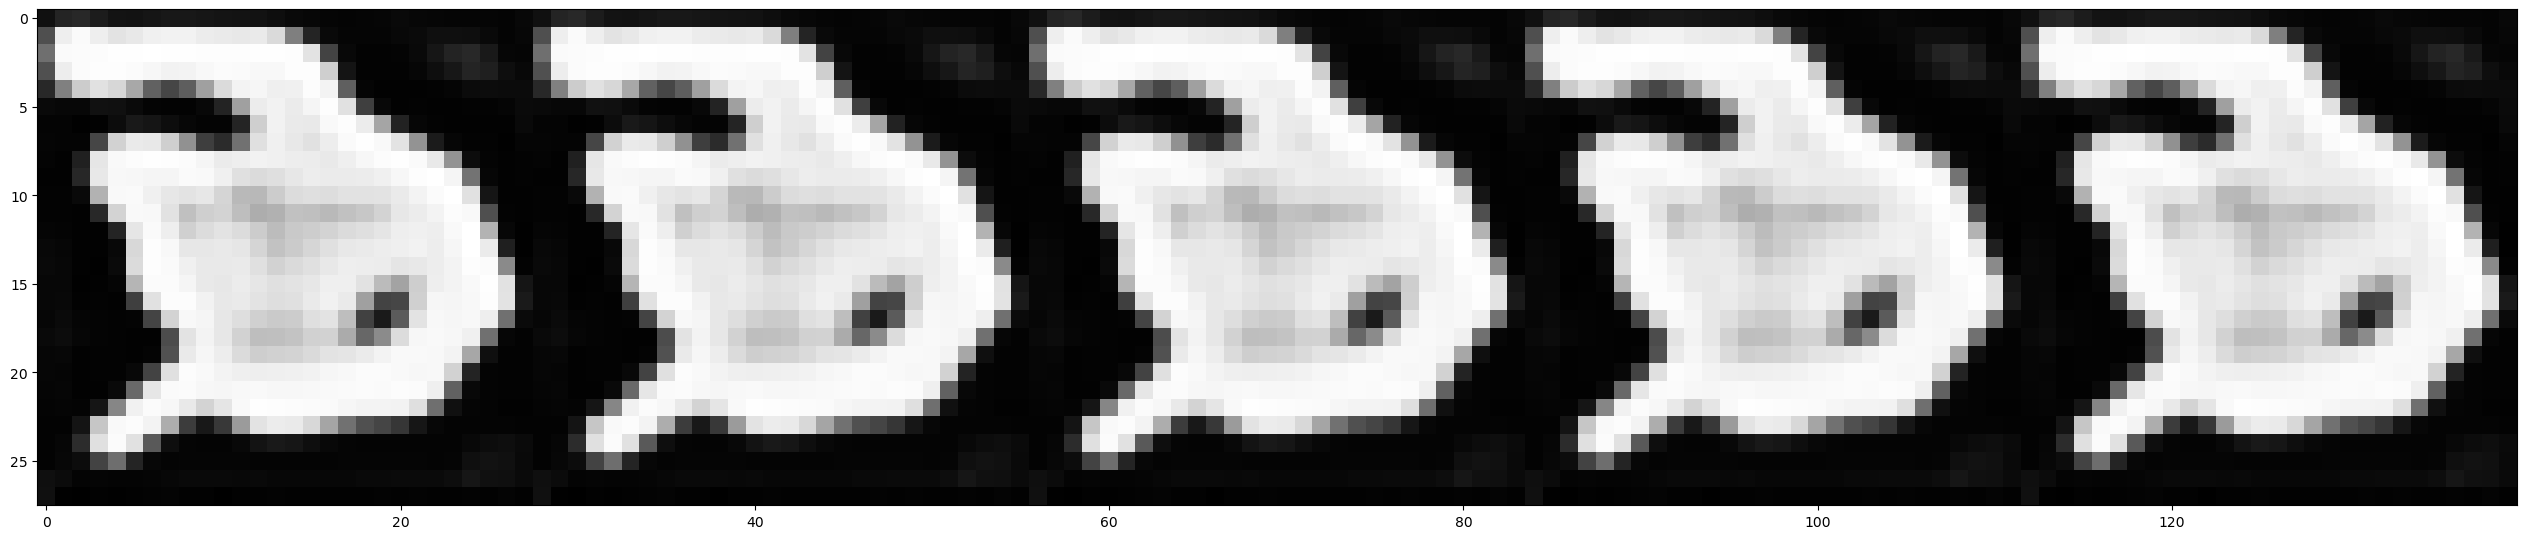

Epoch [70/100] | Train Loss: 0.0353 | Validation Loss: 0.0346
Epoch  70


100%|██████████| 750/750 [00:50<00:00, 14.86it/s]


Epoch [71/100] | Train Loss: 0.0350 | Validation Loss: 0.0363
Epoch  71


100%|██████████| 750/750 [00:50<00:00, 14.78it/s]


Epoch [72/100] | Train Loss: 0.0346 | Validation Loss: 0.0343
Epoch  72


100%|██████████| 100/100 [00:02<00:00, 48.33it/s]


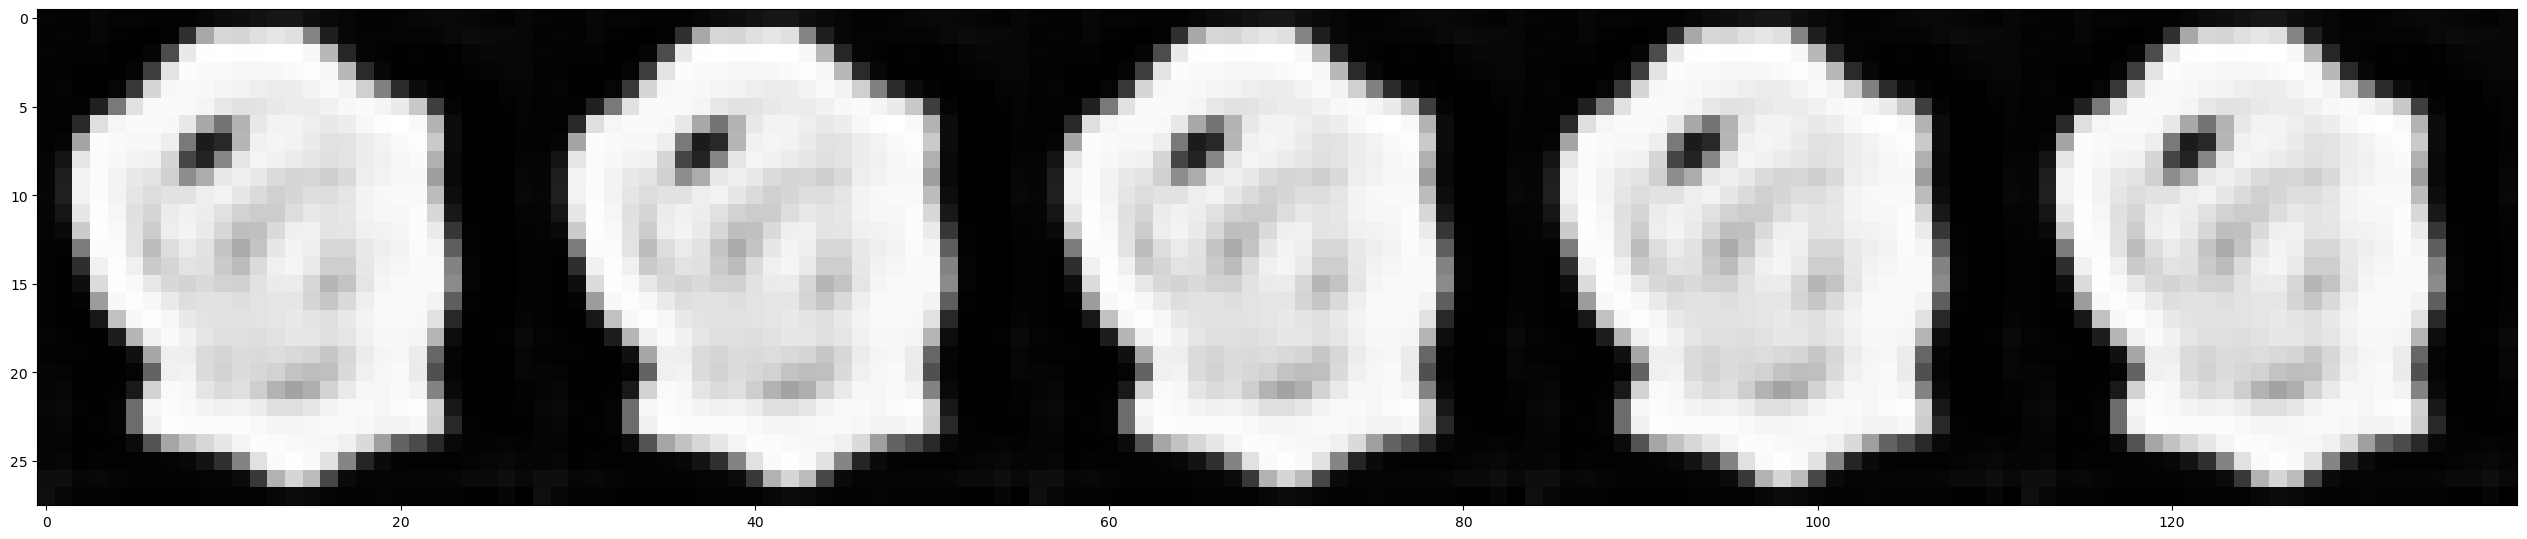

Epoch [73/100] | Train Loss: 0.0343 | Validation Loss: 0.0351
Epoch  73


100%|██████████| 750/750 [00:49<00:00, 15.22it/s]


Epoch [74/100] | Train Loss: 0.0341 | Validation Loss: 0.0376
Epoch  74


100%|██████████| 750/750 [00:48<00:00, 15.54it/s]


Epoch [75/100] | Train Loss: 0.0345 | Validation Loss: 0.0315
Epoch  75


100%|██████████| 100/100 [00:01<00:00, 60.47it/s]


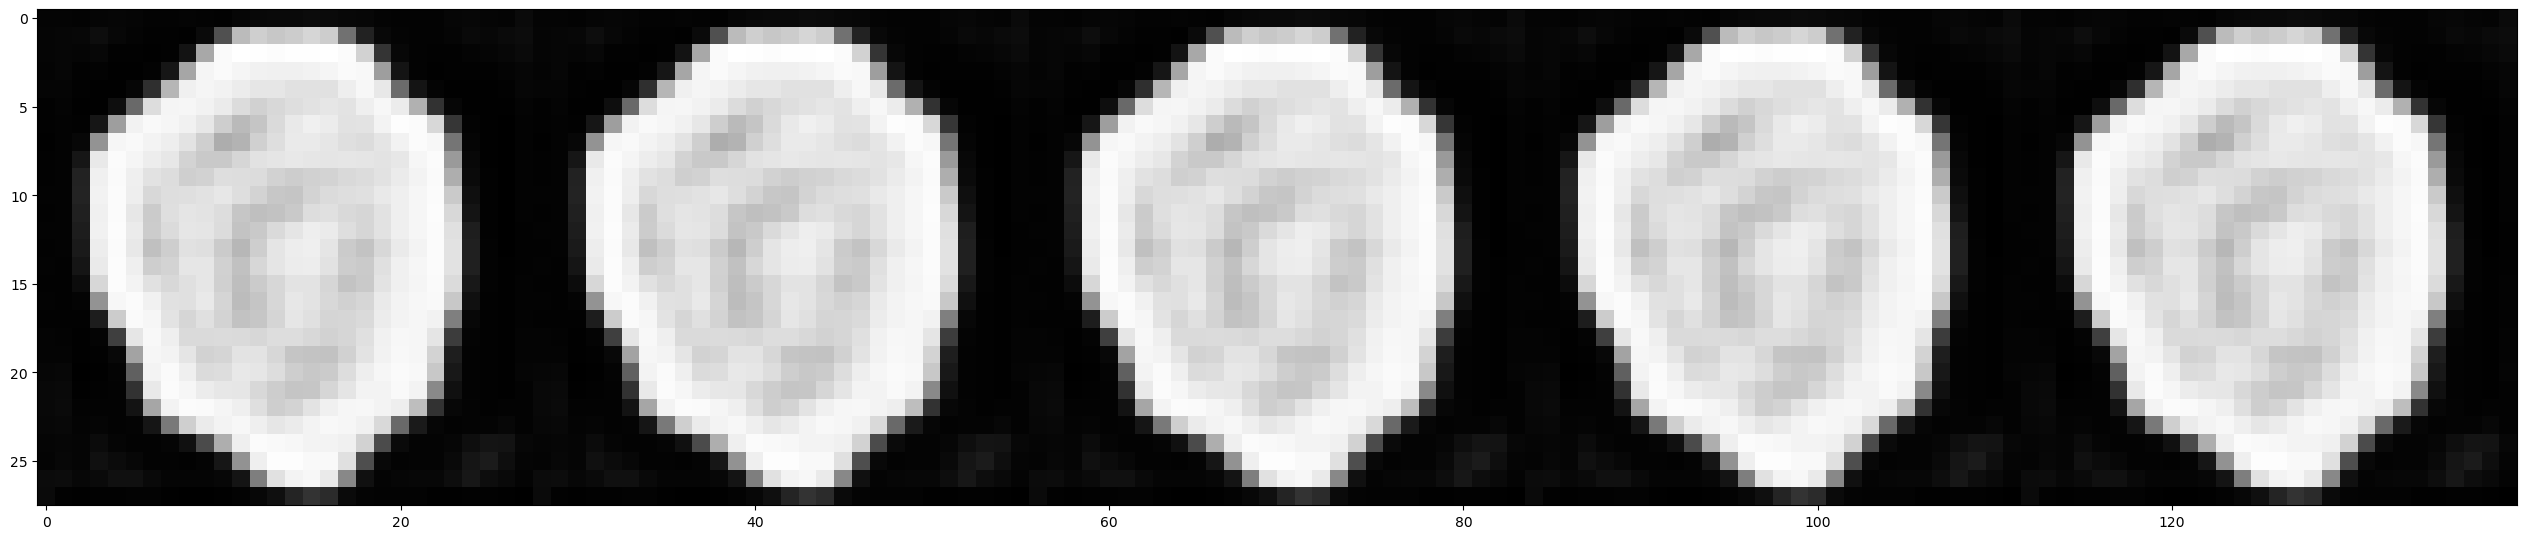

Epoch [76/100] | Train Loss: 0.0340 | Validation Loss: 0.0308
Epoch  76


100%|██████████| 750/750 [00:48<00:00, 15.59it/s]


Epoch [77/100] | Train Loss: 0.0346 | Validation Loss: 0.0330
Epoch  77


100%|██████████| 750/750 [00:48<00:00, 15.59it/s]


Epoch [78/100] | Train Loss: 0.0350 | Validation Loss: 0.0308
Epoch  78


100%|██████████| 100/100 [00:01<00:00, 59.89it/s]


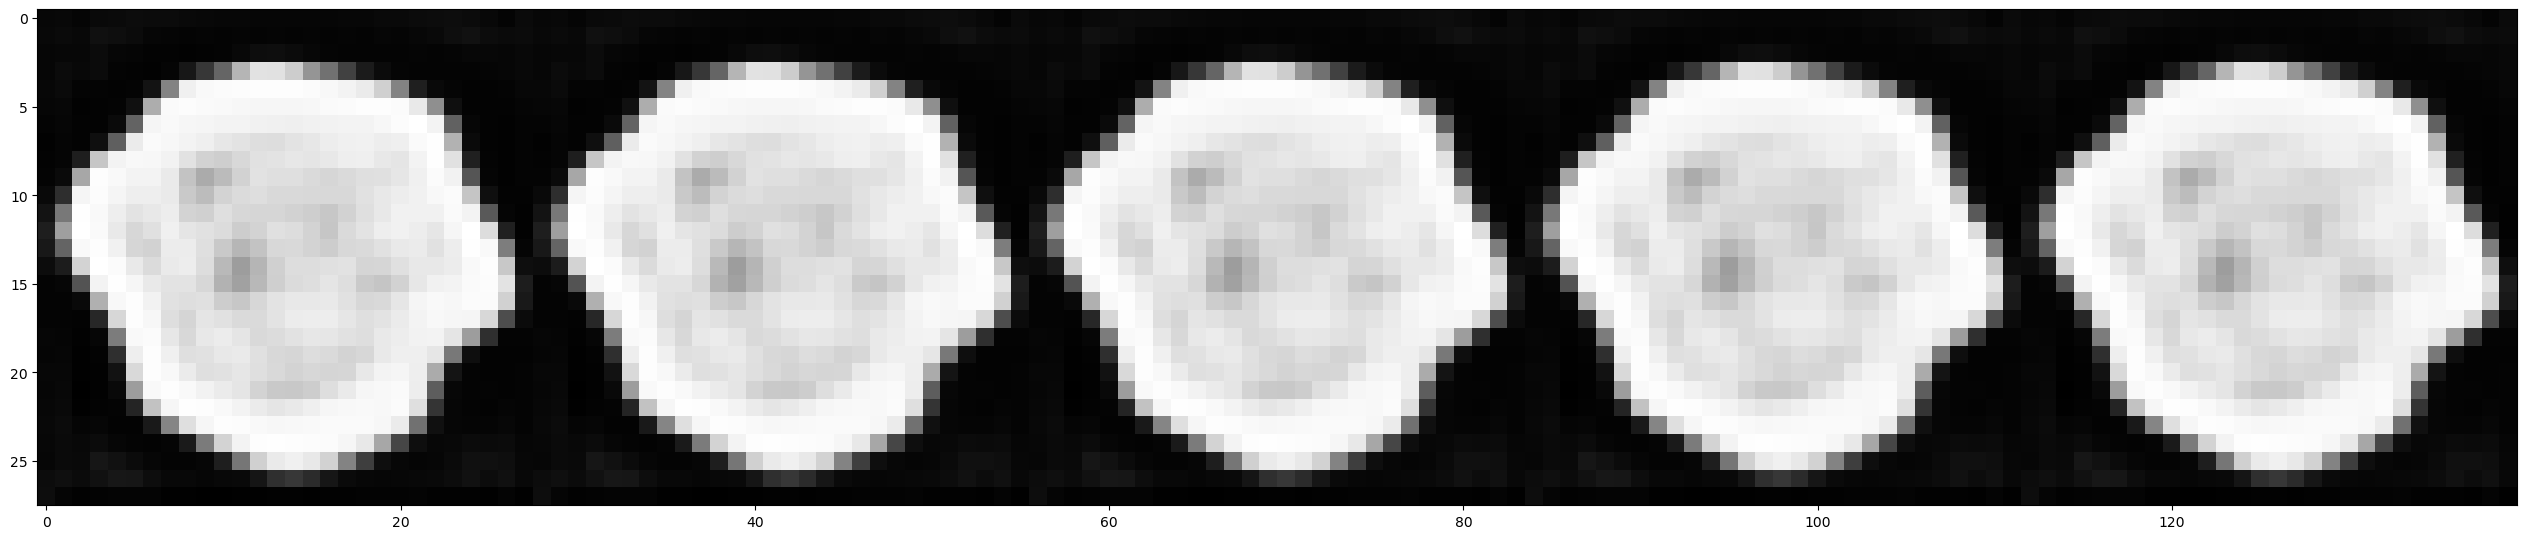

Epoch [79/100] | Train Loss: 0.0329 | Validation Loss: 0.0356
Epoch  79


100%|██████████| 750/750 [00:48<00:00, 15.55it/s]


Epoch [80/100] | Train Loss: 0.0334 | Validation Loss: 0.0324
Epoch  80


100%|██████████| 750/750 [00:48<00:00, 15.54it/s]


Epoch [81/100] | Train Loss: 0.0320 | Validation Loss: 0.0306
Epoch  81


100%|██████████| 100/100 [00:01<00:00, 60.46it/s]


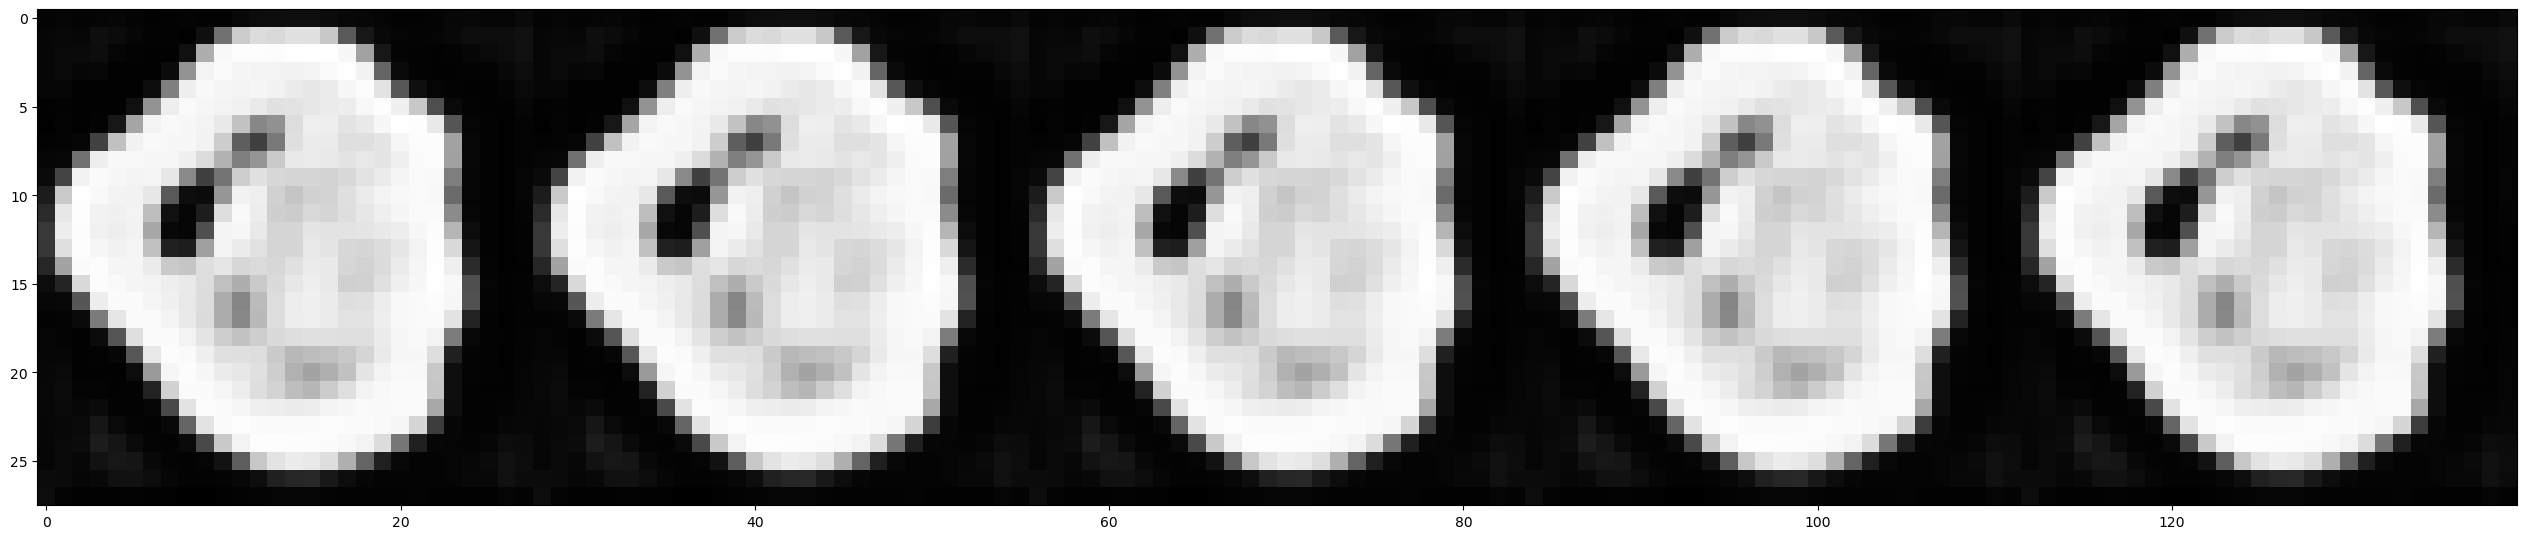

Epoch [82/100] | Train Loss: 0.0331 | Validation Loss: 0.0299
Epoch  82


100%|██████████| 750/750 [00:48<00:00, 15.56it/s]


Epoch [83/100] | Train Loss: 0.0324 | Validation Loss: 0.0299
Epoch  83


100%|██████████| 750/750 [00:48<00:00, 15.53it/s]


Epoch [84/100] | Train Loss: 0.0320 | Validation Loss: 0.0341
Epoch  84


100%|██████████| 100/100 [00:01<00:00, 60.15it/s]


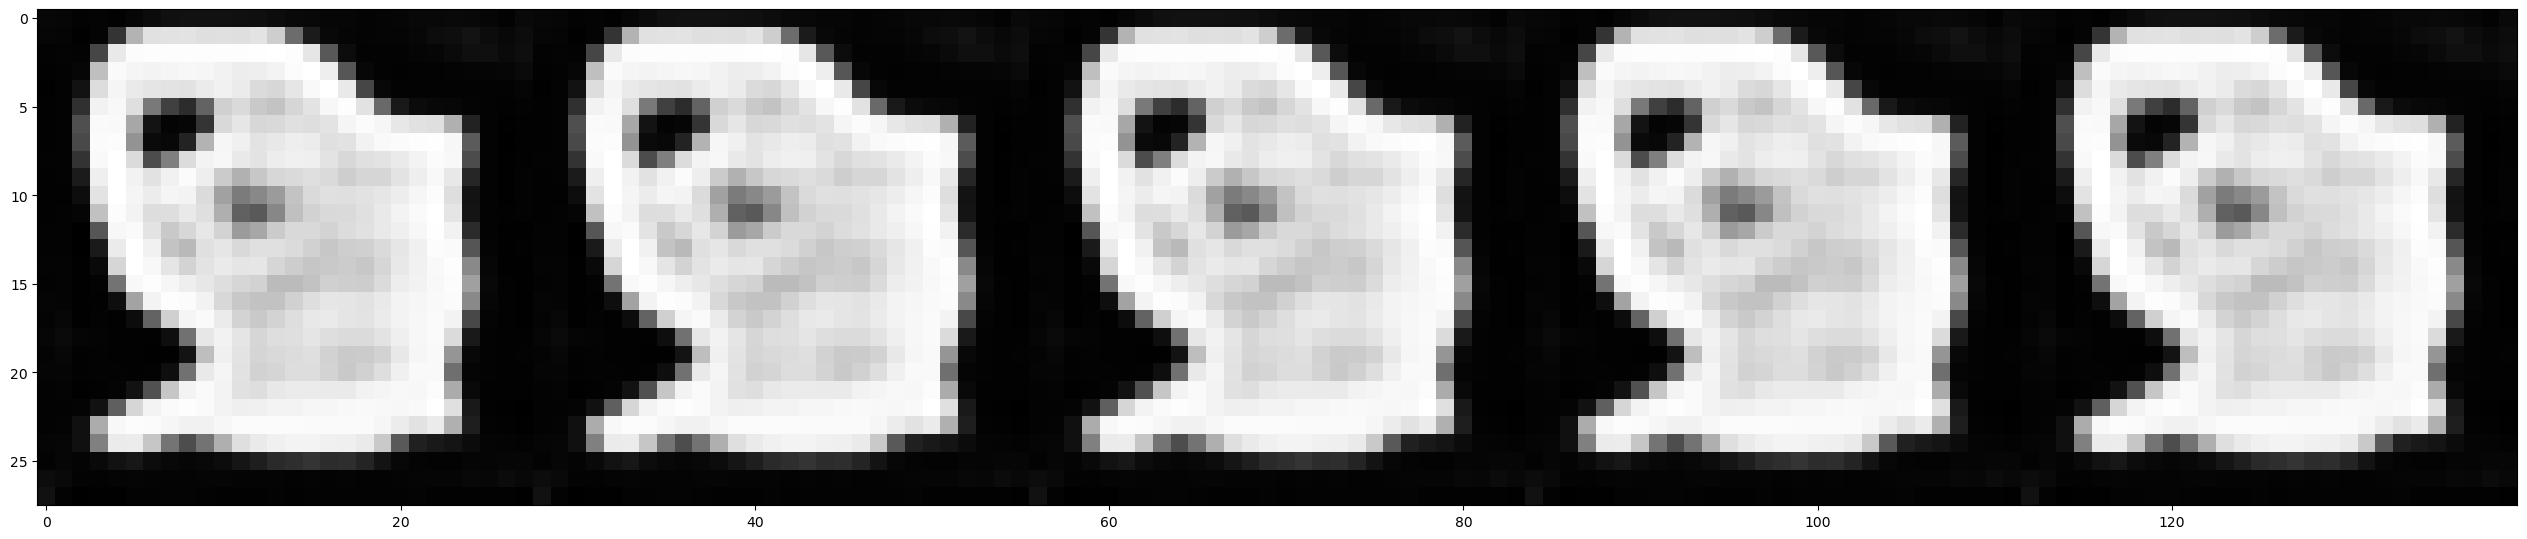

Epoch [85/100] | Train Loss: 0.0323 | Validation Loss: 0.0304
Epoch  85


100%|██████████| 750/750 [00:48<00:00, 15.53it/s]


Epoch [86/100] | Train Loss: 0.0308 | Validation Loss: 0.0322
Epoch  86


100%|██████████| 750/750 [00:48<00:00, 15.56it/s]


Epoch [87/100] | Train Loss: 0.0314 | Validation Loss: 0.0292
Epoch  87


100%|██████████| 100/100 [00:01<00:00, 60.34it/s]


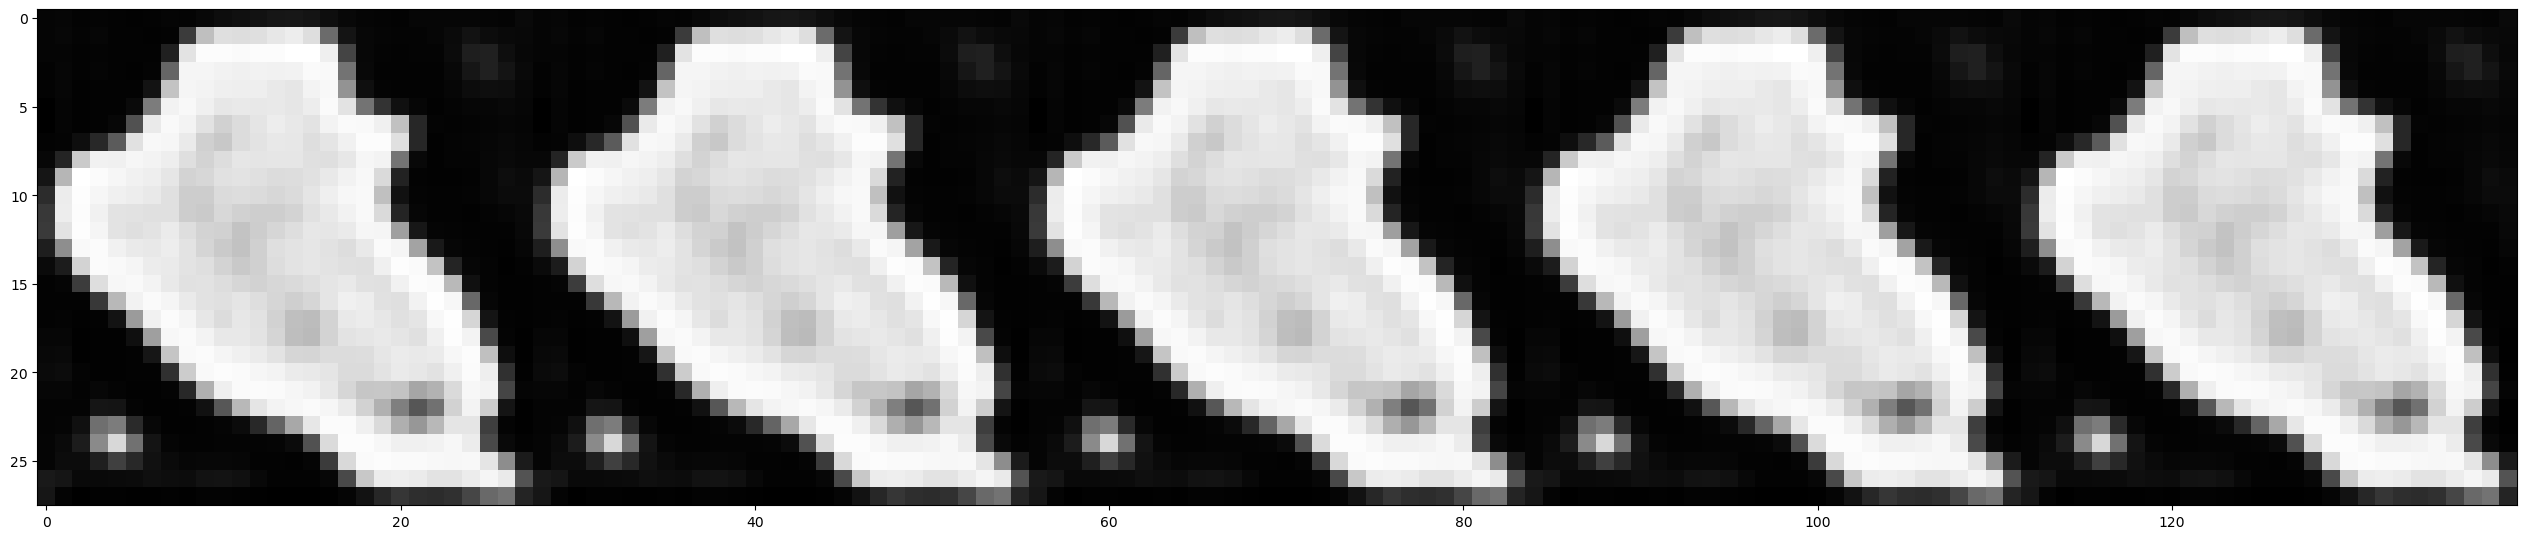

Epoch [88/100] | Train Loss: 0.0320 | Validation Loss: 0.0304
Epoch  88


100%|██████████| 750/750 [00:48<00:00, 15.55it/s]


Epoch [89/100] | Train Loss: 0.0317 | Validation Loss: 0.0295
Epoch  89


100%|██████████| 750/750 [00:48<00:00, 15.43it/s]


Epoch [90/100] | Train Loss: 0.0307 | Validation Loss: 0.0312
Epoch  90


100%|██████████| 100/100 [00:01<00:00, 60.32it/s]


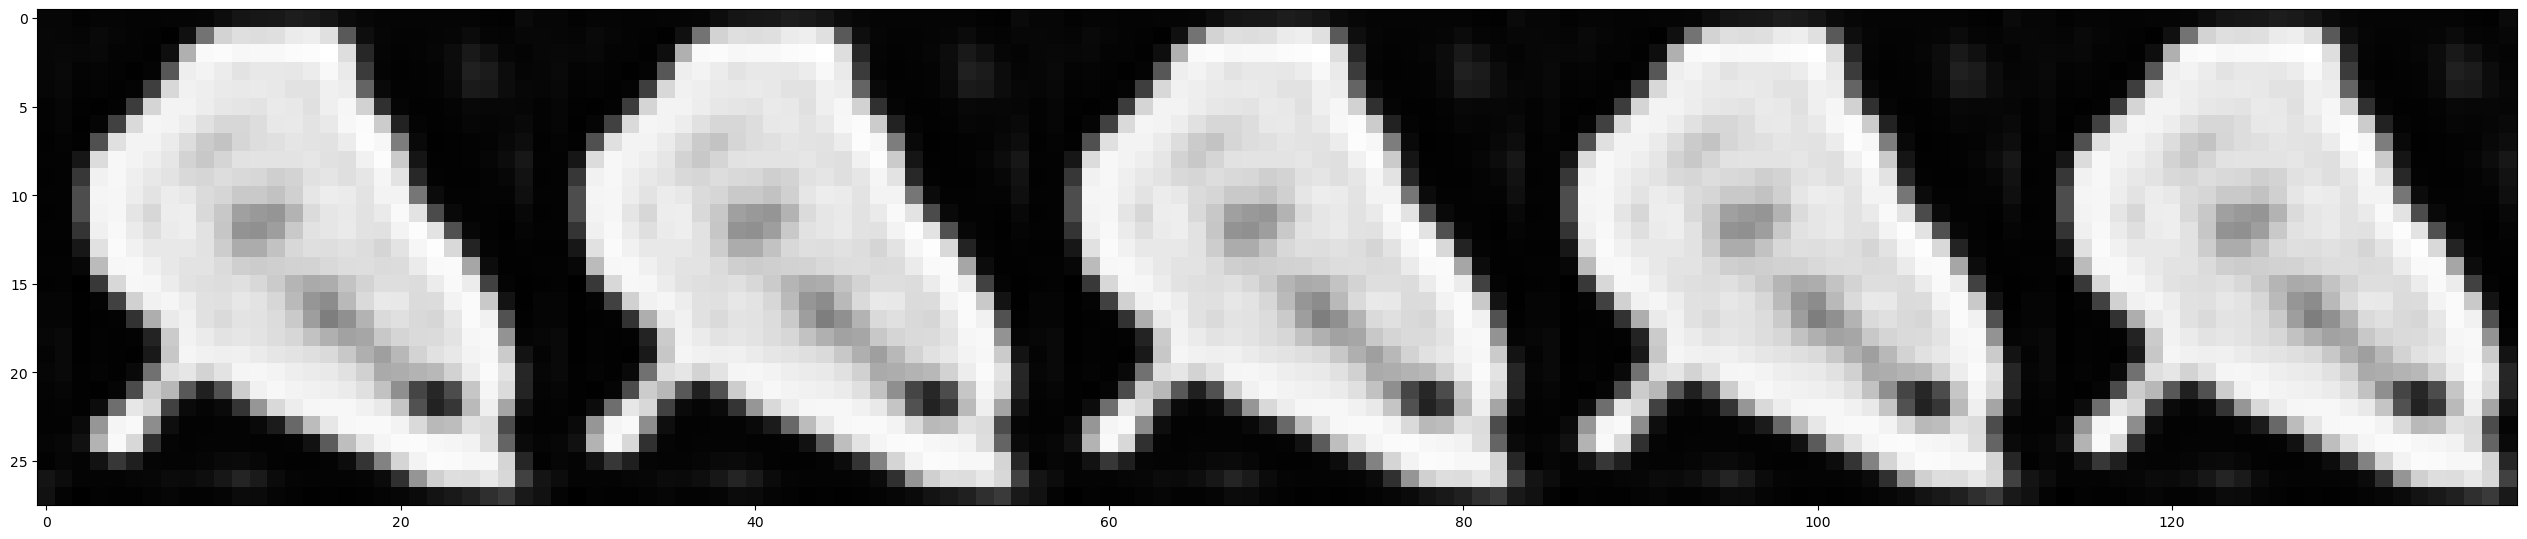

Epoch [91/100] | Train Loss: 0.0297 | Validation Loss: 0.0291
Epoch  91


100%|██████████| 750/750 [00:48<00:00, 15.32it/s]


Epoch [92/100] | Train Loss: 0.0296 | Validation Loss: 0.0290
Epoch  92


100%|██████████| 750/750 [00:48<00:00, 15.42it/s]


Epoch [93/100] | Train Loss: 0.0297 | Validation Loss: 0.0269
Epoch  93


100%|██████████| 100/100 [00:01<00:00, 59.94it/s]


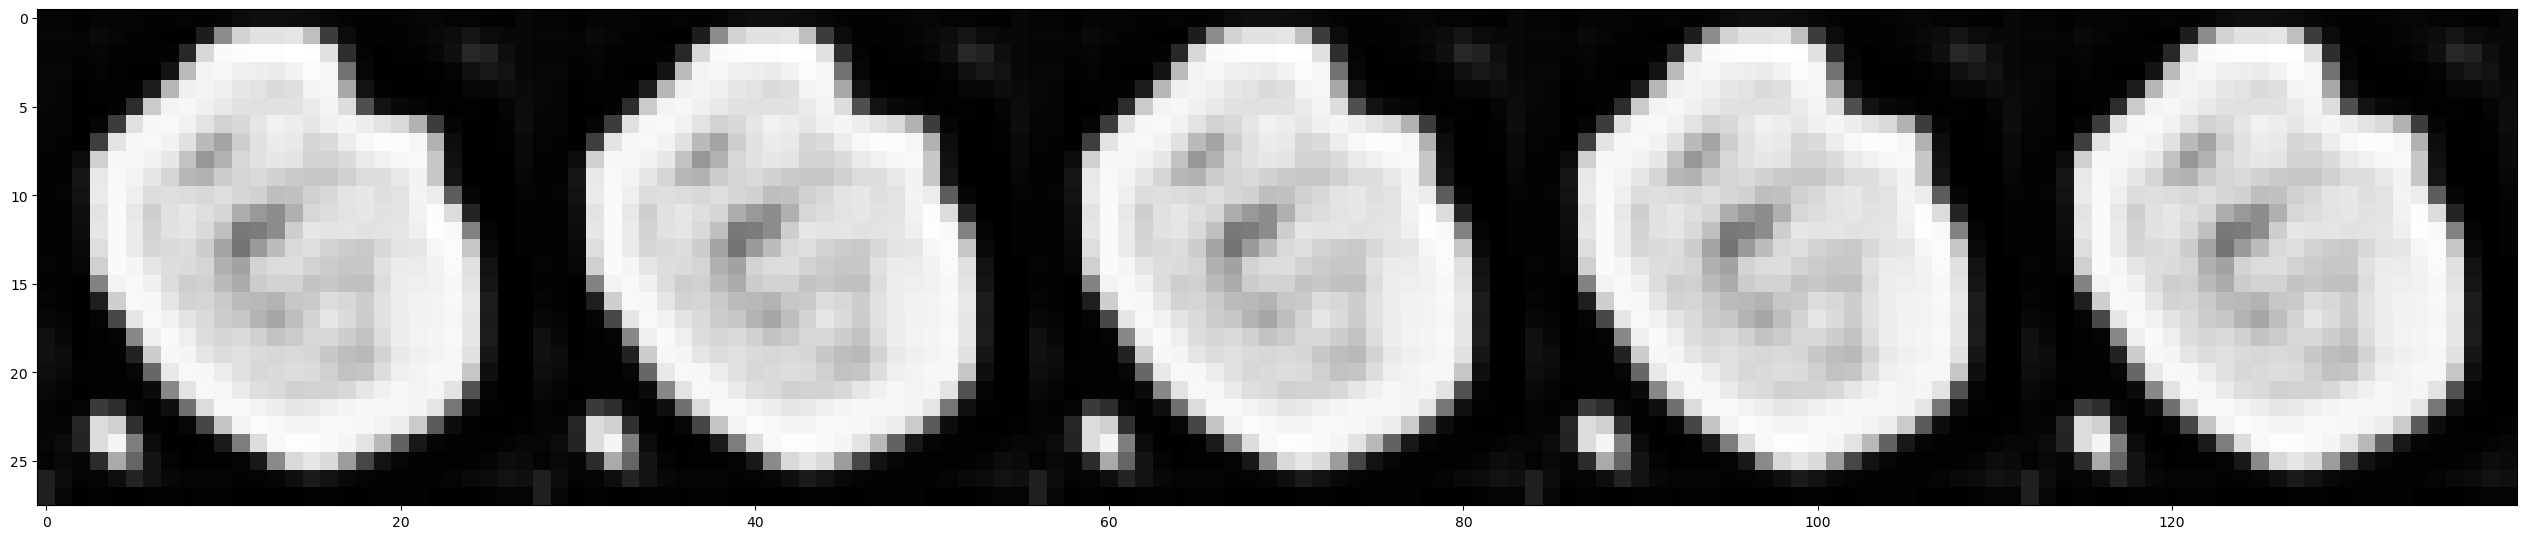

Epoch [94/100] | Train Loss: 0.0306 | Validation Loss: 0.0332
Epoch  94


100%|██████████| 750/750 [00:48<00:00, 15.43it/s]


Epoch [95/100] | Train Loss: 0.0319 | Validation Loss: 0.0272
Epoch  95


100%|██████████| 750/750 [00:48<00:00, 15.61it/s]


Epoch [96/100] | Train Loss: 0.0307 | Validation Loss: 0.0259
Epoch  96


100%|██████████| 100/100 [00:01<00:00, 63.24it/s]


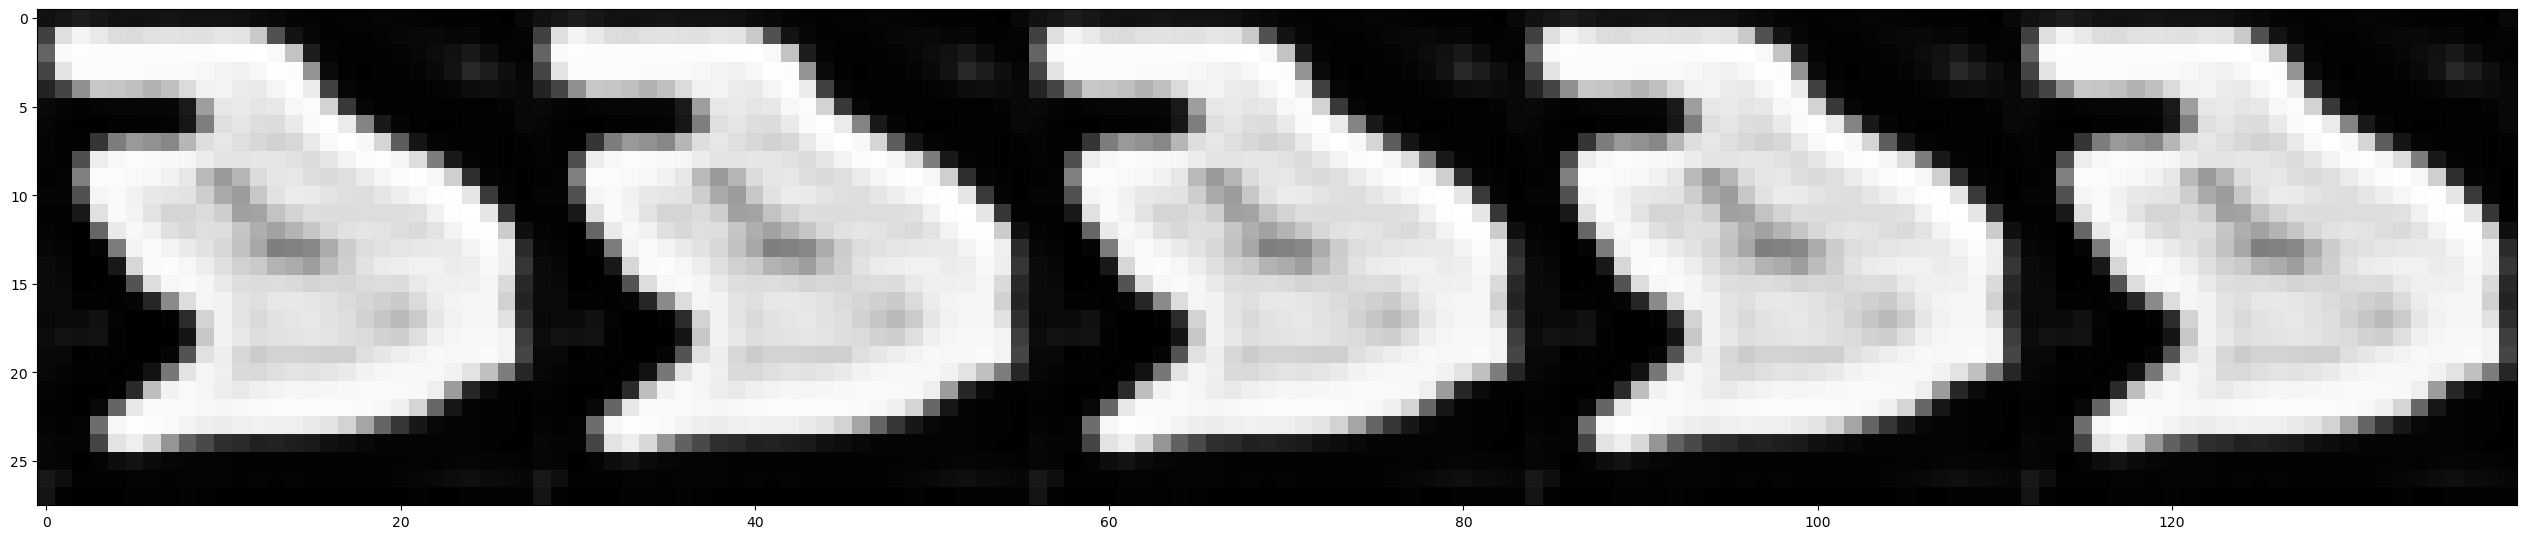

Epoch [97/100] | Train Loss: 0.0288 | Validation Loss: 0.0290
Epoch  97


100%|██████████| 750/750 [00:46<00:00, 16.03it/s]


Epoch [98/100] | Train Loss: 0.0296 | Validation Loss: 0.0277
Epoch  98


100%|██████████| 750/750 [00:46<00:00, 16.08it/s]


Epoch [99/100] | Train Loss: 0.0281 | Validation Loss: 0.0295
Epoch  99


100%|██████████| 100/100 [00:02<00:00, 46.33it/s]


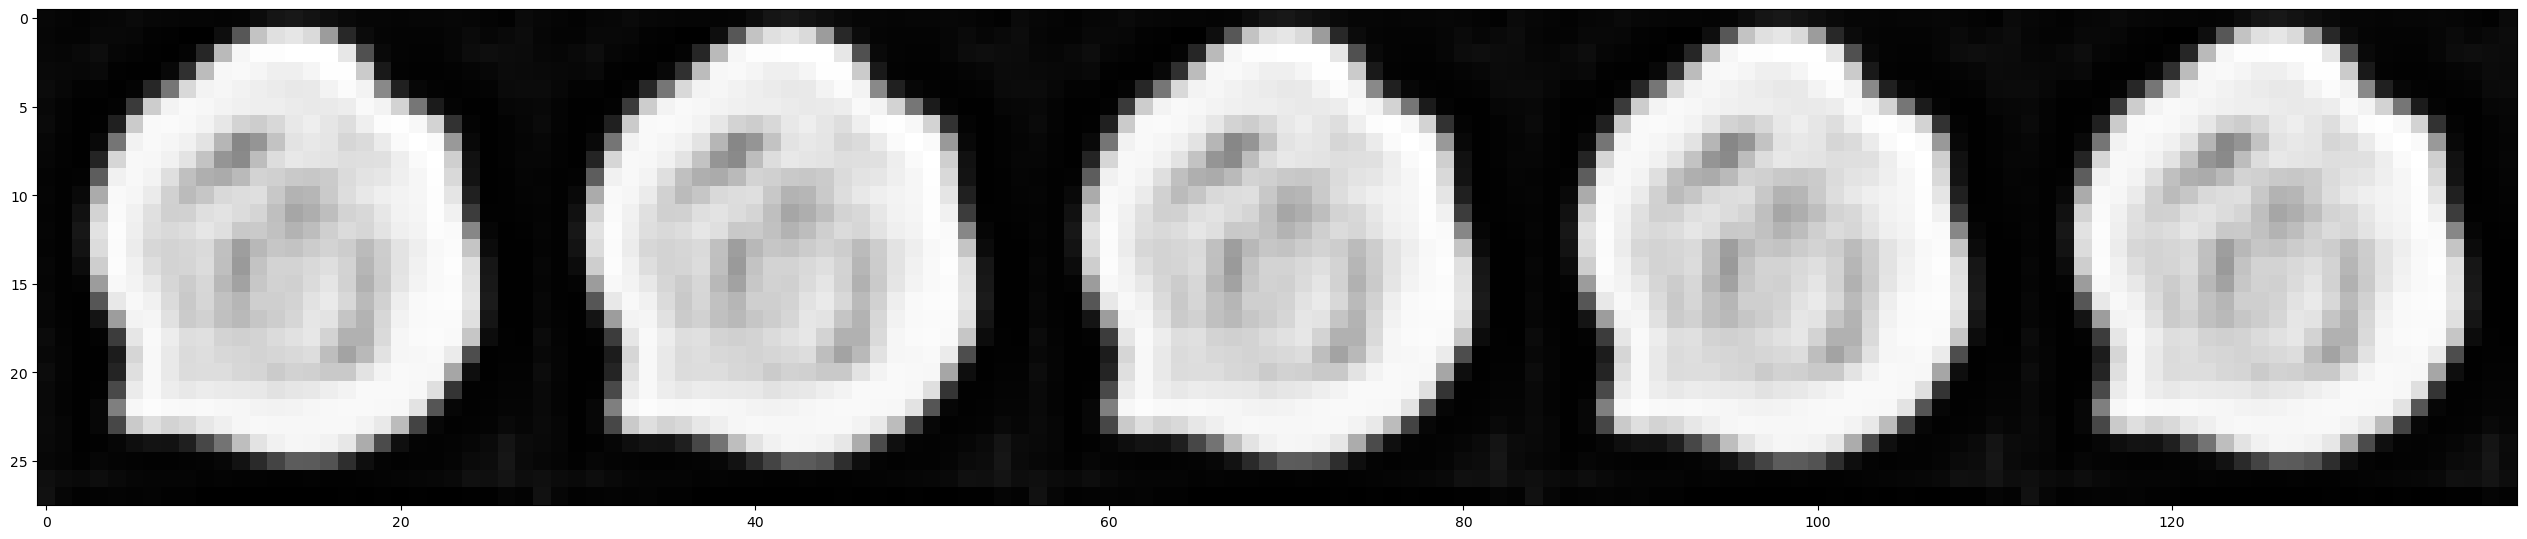

Epoch [100/100] | Train Loss: 0.0289 | Validation Loss: 0.0277


In [121]:
# Set the noise function to be used for training
noise_function = diffusion.blur
# noise_function = diffusion.vignette
# noise_function = diffusion.pixellate

for epoch in range(EPOCHS):
    print("Epoch ",epoch)
    train_loss = 0
    for x, _ in tqdm(train_loader):
        optimizer.zero_grad()
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t = noise_function(x, t)
        pred = model(x_t, t)
        loss = loss_fn(pred, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for x, _ in val_loader:
            #print(type(x))
            #print(x.shape)
            x = x.to(device)
            t = diffusion.sample_timesteps(x.shape[0]).to(device)
            x_t = noise_function(x, t)
            pred = model(x_t, t)
            batch_val_loss = loss_fn(pred, x)
            val_loss += batch_val_loss.item()
    
    # Sample only every 3 epochs for opt purposes
    if epoch%3 == 0:
        sampled_images = diffusion.sample(model, batch_size=5)
        plot_images(sampled_images)
        
    # Save loss
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    print(f"Epoch [{epoch+1}/100] | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

In [ ]:
torch.save(model.state_dict(), './Models/DM/coldDiff1')

In [ ]:
diff2 = coldDiff()
sampled_images = diff2.sample(model, batch_size=5)
plot_images(sampled_images)

In [ ]:
# Manually create loss record since I forgot to add the append.
train_losses = []
val_losses = []

In [ ]:
### Save model
torch.save(model.state_dict(), './Models/DM/diffusion2')

### FID

In [ ]:
from inception import InceptionV3
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm


def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1-mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1+sigma2- 2*covmean)
    return fid

def get_activations(images, model, batch_size=32, dims=2048, device='cuda'):
    model.eval()
    pred_arr = np.empty((len(images), dims))
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            start = i
            end = i+batch_size
            batch = images[start:end].to(device)
            #print(batch.size())
            #raise
            pred = model(batch)[0]
            pred = F.adaptive_avg_pool2d(pred, output_size=(1,1))
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start:end] = pred
    return pred_arr

#inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.fc = torch.nn.Identity()
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

In [49]:
original_images = []
generated_images = []

model.eval()
with torch.no_grad():
    for x, t in train_loader:
        original_images.append(x)
        sampled = diffusion.sample(model, n=x.shape[0])
        generated_images.append(sampled)
        
original_images = torch.stack(original_images)
generated_images = torch.stack(generated_images)

TypeError: coldDiff.sample() got an unexpected keyword argument 'n'

In [50]:
generated_images.size()

AttributeError: 'list' object has no attribute 'size'

In [ ]:
original_images = torch.stack(original_images[:-1])
generated_images = torch.stack(generated_images)

In [ ]:
transform = torchvision.transforms.Compose([
    #transforms.Grayscale(3)
    torchvision.transforms.Lambda(lambda x: x.repeat(1, 1, 3, 1, 1))
])

original_transformed = []
generated_transformed = []

for i in range(len(generated_images)):
    original_transformed.append(transform(original_images[i].squeeze()))
    generated_transformed.append(transform(generated_images[i].squeeze()))
    
original_transformed = torch.stack(original_transformed)
generated_transformed = torch.stack(generated_transformed)

In [ ]:
generated_transformed.size()

In [ ]:
generated_transformed = generated_transformed/255 - 1

In [ ]:
import numpy as np

original_activations = get_activations(original_transformed, inception_model, device=device)
generated_activations = get_activations(generated_transformed, inception_model, device=device)

# Calculate mean and covariance of the activations
mu1 = np.mean(original_activations, axis=0)
sigma1 = np.cov(original_activations, rowvar=False)
mu2 = np.mean(generated_activations, axis=0)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print('FID score:', fid_score)

### Use GMM to sample images

In [ ]:
from sklearn.mixture import GaussianMixture

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

diffusion = coldDiff()

fully_degraded_images = []

for x, _ in test_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0]).to(device)
    x_t = diffusion.blur(x, t)
    flattened_images = x_t.view(x_t.size(0), -1).detach().cpu().numpy()
    fully_degraded_images.extend(flattened_images)

    
fully_degraded_images = np.array(fully_degraded_images)

gmm = GaussianMixture(n_components=3)
gmm.fit(fully_degraded_images)

In [ ]:
n_samples = 100
sampled_images = gmm.sample(n_samples)[0]
initial_images = torch.tensor(sampled_images).float().to(device)
initial_images = initial_images.view(n_samples, 1, 28, 28)
plot_images(initial_images)

In [ ]:
initial_images.shape

In [ ]:
sampled_intensities = gmm.sample(n_samples)

In [ ]:
len(sampled_intensities)

In [ ]:
import joblib

In [ ]:
joblib.dump(gmm, 'Models/DM/gmm_blur_coldDiff.joblib')